## **Trading Strategy**

In [220]:
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import zscore
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from datetime import timedelta as td
import statsmodels.api as sm
import random
from functools import reduce
from scipy.stats import skew, kurtosis
import quandl

### **Downloading Data**

#### **H Value Data**

In [221]:
realised_h_df = pd.read_csv(r'..//Realized_H/Realized_H_Data2.csv')
realised_h_df.rename(columns={'Realized_H':'H_value'}, inplace=True)
realised_h_df

,date,ticker,price,H_value
0,2010-01-29,ORCL,23.06000,0.049828
1,2010-02-26,ORCL,24.65000,0.005427
2,2010-03-31,ORCL,25.71000,0.108720
3,2010-04-30,ORCL,25.86750,0.023036
4,2010-05-28,ORCL,22.57000,7.055720
...,...,...,...,...
15457,2023-04-28,TSLA,164.31000,0.030113
15458,2023-05-31,TSLA,203.92999,0.023652
15459,2023-06-30,TSLA,261.76999,0.035020
15460,2023-07-31,TSLA,267.42999,0.026858


In [222]:
implied_h_df = pd.read_csv(r'../Implied_H/H_values_output_options_final_monthly.csv')
implied_h_df.rename(columns={'Price':'price','Ticker':'ticker','Date':'date','close': 'price'}, inplace=True)
implied_h_df

,ticker,date,price,H_value
0,AAPL,2010-01-29,192.063,0.418456
1,AAPL,2010-02-26,204.620,0.115471
2,AAPL,2010-03-31,235.000,0.341356
3,AAPL,2010-04-30,261.090,0.419943
4,AAPL,2010-05-31,256.880,0.042454
...,...,...,...,...
14666,XOM,2023-04-28,118.340,0.126797
14667,XOM,2023-05-31,102.180,0.134396
14668,XOM,2023-06-30,107.250,0.238618
14669,XOM,2023-07-31,107.240,0.292218


#### **Downloading Daily blended LIBOR/SOFR Data**

In [223]:
sofr_data = pd.read_csv(r"/Users/pr/Downloads/UChicago MSFM/Winter Quarter/QTS/Project/buy-rough-sell-smooth/FINM33150_Interp_LIBOR_SOFR_to_2025.tab", sep="\t")
# Rename the first column to "date"
sofr_data.rename(columns={sofr_data.columns[0]: "date", sofr_data.columns[1]:"sofr"}, inplace=True)

import pandas as pd

# Example: sofr_data has columns ["date", "sofr"] with daily data
# 1) Convert "date" column to datetime
sofr_data["date"] = pd.to_datetime(sofr_data["date"])

# 2) Sort by date to ensure chronological order
sofr_data.sort_values("date", inplace=True)

# 3) Set "date" as the index (needed for rolling)
sofr_data.set_index("date", inplace=True)

# 4) Forward-fill any missing SOFR values
sofr_data["sofr"] = sofr_data["sofr"].ffill()

# 5) Compute the 3-month (90-day) rolling average
#    If you want at least some average even when fewer than 90 days of data are available, use min_periods=1
sofr_data["sofr_3M_Rolling_Avg"] = sofr_data["sofr"].rolling(window=90, min_periods=1).mean()

# 6) (Optional) Reset the index so "date" is a column again
sofr_data.reset_index(inplace=True)

# Display the result
print(sofr_data.tail())


            date  sofr  sofr_3M_Rolling_Avg
10185 2025-01-16  4.29             4.671556
10186 2025-01-17  4.29             4.660000
10187 2025-01-20  4.29             4.647889
10188 2025-01-21  4.29             4.635778
10189 2025-01-22  4.30             4.624333


#### **Downloading Monthly Ticker Values**

In [224]:
monthly_prices = pd.read_csv(r"/Users/pr/Downloads/UChicago MSFM/Winter Quarter/QTS/Project/buy-rough-sell-smooth/monthly_ticker_prices.csv")
monthly_prices

,PERMNO,date,TICKER,PRC
0,10104,2010-01-29,ORCL,23.06000
1,10104,2010-02-26,ORCL,24.65000
2,10104,2010-03-31,ORCL,25.71000
3,10104,2010-04-30,ORCL,25.86750
4,10104,2010-05-28,ORCL,22.57000
...,...,...,...,...
17752,93436,2023-04-28,TSLA,164.31000
17753,93436,2023-05-31,TSLA,203.92999
17754,93436,2023-06-30,TSLA,261.76999
17755,93436,2023-07-31,TSLA,267.42999


### Downloading SPY data 

- for calculating downside beta later on

In [225]:
pravallika = {'Quandl':'Ccbn7K3VToRXnKFzzH2X'}

In [226]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=pravallika['Quandl'], **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

In [227]:
eod_price_data = fetch_quandl_table('QUOTEMEDIA/PRICES', avoid_download=True)

Skipping any possible download of QUOTEMEDIA/PRICES


In [228]:
import pandas as pd

# Filter for SPY data and sort by date
spy_df = eod_price_data[eod_price_data["ticker"] == "SPY"].copy()
spy_df = spy_df.sort_values("date")

# Convert 'date' column to datetime
spy_df["date"] = pd.to_datetime(spy_df["date"])

# Resample to get the last business day of each month (BM frequency)
monthly_spy = spy_df.set_index("date").resample("BM").last().reset_index()

# Keep only the necessary columns
monthly_spy = monthly_spy[["date", "adj_close"]]

# Compute monthly returns as a fraction (e.g., 0.02 means +2%)
monthly_spy["spy_return"] = monthly_spy["adj_close"].pct_change().fillna(0)

display(monthly_spy.head())

/var/folders/ym/jy9bfkc1719_43grtmk04syw0000gn/T/ipykernel_80678/4130195462.py:11: FutureWarning: 'BM' is deprecated and will be removed in a future version, please use 'BME' instead.
  monthly_spy = spy_df.set_index("date").resample("BM").last().reset_index()


,date,adj_close,spy_return
0,1993-01-29,24.358021,0.000000
1,1993-02-26,24.617858,0.010667
2,1993-03-31,25.169487,0.022408
3,1993-04-30,24.525427,-0.025589
4,1993-05-31,25.186866,0.026970


### **Trading Strategy Implementation**

#### **Ranking Methodology: Quintile Ranking of H_value**

The ranking process assigns each ticker a rank from 1 to 5 within each month based on its roughness using the Hurst Index (H) values:

1. **Within-Month Sorting:**  
   Tickers are ordered by their H value on each month.  
   - The ticker with the highest H value is placed at the top.
   - The ticker with the lowest H value is placed at the bottom.

2. **Quintile Assignment:**  
   The ordered list is then divided into five equally sized groups (quintiles).  
   - **Rank 1:** Tickers with the highest H values.
   - **Rank 5:** Tickers with the lowest H values.
   - Intermediate ranks indicate middle groupings.

#### **Ranking Interpretation**
Within each month, every ticker receives an integer rank from **1** to **5**:
- **Rank 1:** Represents the most favorable condition for short positions.
- **Rank 5:** Represents the most favorable condition for long positions.
- Tickers with intermediate ranks remain neutral.

---

#### **Signal Generation**

Based on the quintile rankings:
- **Short Signal:** Issued to tickers with a rank equal to the predefined short threshold (Rank 1).
- **Long Signal:** Issued to tickers with a rank equal to the predefined long threshold (Rank 5).
- **Neutral:** Tickers with intermediate ranks receive no position.

By default, the strategy assumes trading 1 share per asset, though this can be adjusted as needed.

---

#### **Position Allocation**
At the start of each canonical monthly date (from the monthly_prices data):
- **Closing Positions:**  
  Any open positions from the previous month are closed at the current month’s price, realizing PnL and incurring closing transaction costs.
- **Opening New Positions:**  
  - **If New Signal Data is Available:**  
    New positions are opened at the current month’s ticker prices.  
    - **Equal Allocation:** If weighted_allocation is set to False, each ticker in a group (longs or shorts) receives an equal share of the allocated capital.
    - **Weighted Allocation:** If weighted_allocation is True, then:
      - **For Longs:** The allocation is weighted by `(max(H_value) - H_value)` so that tickers with lower H_value receive a higher weight.
      - **For Shorts:** The allocation is weighted by `(H_value - min(H_value))` so that tickers with higher H_value receive a higher weight.
    Opening positions incurs an opening transaction cost (a fraction of the allocated capital).
  - **If Signal Data is Missing for a particular month:**  
    The strategy closes any open positions (realizing PnL, subject to closing costs) and does not open new positions. This ensures that positions are never inadvertently carried over beyond the month with available h-value data.

#### **Profit/Loss (PnL) and Return Calculation**
- **Realized PnL:**  
  - For each month, the PnL is calculated from closing positions:
  
    $$
    \text{PnL} = \text{Allocation} \times \frac{\text{(Closing Price - Entry Price)}}{\text{Entry Price}}
    $$
  
    (For short positions, the return is reversed.)
  - Transaction costs are subtracted both at closing and opening.

  
- **Portfolio Value Update:**  
  The portfolio value is updated by adding the realized PnL to the previous month’s equity.
  
- **Monthly Return:**  
  Computed as the percentage change in portfolio value relative to the prior month’s equity.
  
- **Cumulative Return:**  
  Calculated as the total gain (or loss) relative to the initial equity.

#### Summary
- **Dynamic Rebalancing:**  
  The portfolio is rebalanced monthly—any open positions are closed each month, and new positions are opened only if valid signal data is available for that month.
  
- **Allocation Flexibility:**  
  Depending on the parameter **weighted_allocation**, allocations among tickers can be either equal or weighted by H_value (favoring lower H_value for longs and higher H_value for shorts).

- **Performance Tracking:**  
  The strategy tracks monthly realized PnL, portfolio value, monthly return, and cumulative return. Additional flags indicate whether a position was opened or closed in a given month.

This methodology ensures that the trading strategy:
- Uses H_value-based quintile ranking to generate clear long/short signals.
- Allocates capital based on either equal or weighted rules.
- Closes positions at each monthly rebalancing date so that positions are not held longer than a month when signal data is missing.
- Computes performance metrics on a normalized, capital-adjusted basis.

In [229]:
# Modify the function to rank h_vals into groups per date
def rank_H_quintiles(df, groups=5):
    # Ensure date column is in datetime format
    monthly = df.copy()
    monthly["date"] = pd.to_datetime(monthly["date"])
    
    # Sort values by date and h_val
    monthly = monthly.sort_values(["date", "H_value"])
    
    # Assign quintile ranks (1 to 5) based on h_val per date
    monthly["h_rank"] = (
    monthly.groupby("date")["H_value"]
    .transform(lambda x: pd.qcut(-x, q=groups, labels=False, duplicates='drop') + 1)
    )
    
    # Sort final result by ticker & date
    monthly = monthly.sort_values(["ticker", "date"]).reset_index(drop=True)
    
    return monthly

In [230]:
def generate_signal(rank_val, long=5, short=1, strat="long-short"):
    """
    Example signal generator for demonstration.
    Adjust as needed for your actual logic.
    """
    if strat == "long":
        return 1 if rank_val == long else 0
    elif strat == "short":
        return -1 if rank_val == short else 0
    else:  # long-short
        if rank_val == long:
            return 1 
        elif rank_val == short:
            return -1
        else:
            return 0

In [231]:
def trading_strategy(
    df,                    # DataFrame: at least ['date','ticker','price','h_rank','H_value']
    monthly_prices,        # DataFrame: columns ['PERMNO','date','TICKER','PRC'] (the canonical set of monthly points)
    long=5,
    short=1,
    transaction_cost=0.00001,     # fraction of allocated capital as transaction cost
    initial_equity=1_000_000,
    leverage=5,
    strat="long/short",
    weighted_allocation=True      # If True, weight allocation by H_value; if False, use equal weighting.
):
    """
    Implements a monthly rebalanced long/short strategy with the following rules:
      Scenario 1: Had an open position → close it (pay closing cost) → if data is available, open new position (pay opening cost).
      Scenario 2: Had an open position → close it (pay closing cost) → if data is missing (NaN), do not open a new position.
      Scenario 3: No position open → if new data is available, open position (pay opening cost).
      Scenario 4: No position open → if data is missing, remain with no position (no cost).

    PnL is realized from closing an old position and new positions are opened based solely on the current month's signal.
    'PRC' is used as fallback if 'price' is missing.
    
    The allocation for new positions can be computed in one of two ways:
      - If weighted_allocation is True: for longs, tickers with lower H_value get higher weight;
        for shorts, tickers with higher H_value get higher weight.
      - Otherwise, allocation is equal (long_exposure/n_long, etc.) as before.

    Returns:
      merged  -> The merged DataFrame with signals and intermediate columns.
      perf_df -> Monthly performance tracking DataFrame with:
                 date, realized_pnl, portfolio_val, monthly_return, cum_return,
                 position_open, position_close, no_position.
    """
    import pandas as pd
    import numpy as np

    ######################################
    # 1) Prepare & Merge Data
    ######################################
    df_copy = df.copy()
    df_copy["date"] = pd.to_datetime(df_copy["date"])
    df_copy.sort_values(["ticker", "date"], inplace=True)

    # Generate signals (if not already present)
    df_copy["h_signal"] = df_copy["h_rank"].apply(lambda r: generate_signal(r, long, short, strat))

    # Convert monthly_prices to datetime and sort
    mp_copy = monthly_prices.copy()
    mp_copy["date"] = pd.to_datetime(mp_copy["date"])
    mp_copy.sort_values(["TICKER", "date"], inplace=True)

    # Merge df_copy onto mp_copy by matching date and TICKER.
    merged = pd.merge(
        mp_copy, 
        df_copy[["date", "ticker", "price", "H_value", "h_rank", "h_signal"]],
        left_on=["date", "TICKER"],
        right_on=["date", "ticker"],
        how="left"
    )
    merged.drop(columns=["ticker"], inplace=True)
    merged.sort_values(["TICKER", "date"], inplace=True, ignore_index=True)

    ######################################
    # 2) Iterate Month-by-Month
    ######################################
    prev_equity = initial_equity

    # Dictionary to track open positions from the prior month.
    # open_positions[ticker] = {"signal": ..., "entry_price": ..., "allocation": ...}
    open_positions = {}

    monthly_pnl_records = []

    all_dates = merged["date"].unique()
    for dt in all_dates:
        current_slice = merged[merged["date"] == dt].copy()

        # Flags to track events this month.
        position_closed = False
        position_opened = False

        # -----------------------------
        # 2A) Close out prior positions
        # -----------------------------
        realized_pnl = 0.0
        if open_positions:
            position_closed = True
            for tk, pos in list(open_positions.items()):
                old_signal = pos["signal"]
                old_price = pos["entry_price"]
                allocation = pos["allocation"]

                # Find the row for this TICKER in the current_slice.
                row_ticker = current_slice[current_slice["TICKER"] == tk]
                if not row_ticker.empty:
                    # Prefer 'price' and fallback to 'PRC'
                    close_price = row_ticker["price"].iloc[0]
                    if pd.isna(close_price):
                        close_price = row_ticker["PRC"].iloc[0]
                    if pd.notna(close_price):
                        ret = (close_price - old_price) / old_price
                        if old_signal == -1:
                            ret = -ret
                        pos_pnl = allocation * ret
                        pos_pnl -= allocation * transaction_cost  # Closing cost
                        realized_pnl += pos_pnl
                    else:
                        realized_pnl -= allocation * transaction_cost
                else:
                    realized_pnl -= allocation * transaction_cost

                # Remove the closed position.
                open_positions.pop(tk)
        
        if pd.isna(realized_pnl):
            realized_pnl = 0.0

        portfolio_val_after_close = prev_equity + realized_pnl

        # -----------------------------
        # 2B) Open new positions this month
        # -----------------------------
        valid_slice = current_slice.dropna(subset=["h_signal"])

        # Split into long and short slices.
        long_slice = valid_slice[valid_slice["h_signal"] == 1].copy()
        short_slice = valid_slice[valid_slice["h_signal"] == -1].copy()
        n_long = len(long_slice)
        n_short = len(short_slice)

        total_exposure = portfolio_val_after_close
        long_exposure = total_exposure / 2 if n_long > 0 else 0
        short_exposure = total_exposure / 2 if n_short > 0 else 0

        if weighted_allocation:
            # For long positions: weight = max(H_value) - H_value.
            if n_long > 0:
                long_slice["weight"] = long_slice["H_value"].max() - long_slice["H_value"]
                weight_sum = long_slice["weight"].sum()
                if weight_sum != 0:
                    long_slice["weight"] = long_slice["weight"] / weight_sum
                else:
                    long_slice["weight"] = 1.0 / n_long
            # For short positions: weight = H_value - min(H_value).
            if n_short > 0:
                short_slice["weight"] = short_slice["H_value"] - short_slice["H_value"].min()
                weight_sum = short_slice["weight"].sum()
                if weight_sum != 0:
                    short_slice["weight"] = short_slice["weight"] / weight_sum
                else:
                    short_slice["weight"] = 1.0 / n_short
        else:
            # Equal weighting.
            if n_long > 0:
                long_slice["weight"] = 1.0 / n_long
            if n_short > 0:
                short_slice["weight"] = 1.0 / n_short

        # Open positions for longs.
        if n_long > 0:
            for idx, row in long_slice.iterrows():
                tk = row["TICKER"]
                open_price = row["price"]
                if pd.isna(open_price):
                    continue
                allocation = long_exposure * row["weight"]
                open_cost = allocation * transaction_cost
                realized_pnl -= open_cost
                open_positions[tk] = {"signal": 1, "entry_price": open_price, "allocation": allocation}
            position_opened = True

        # Open positions for shorts.
        if n_short > 0:
            for idx, row in short_slice.iterrows():
                tk = row["TICKER"]
                open_price = row["price"]
                if pd.isna(open_price):
                    continue
                allocation = short_exposure * row["weight"]
                open_cost = allocation * transaction_cost
                realized_pnl -= open_cost
                open_positions[tk] = {"signal": -1, "entry_price": open_price, "allocation": allocation}
            position_opened = True

        # -----------------------------
        # 2C) Record performance for this month.
        # -----------------------------
        new_equity = prev_equity + realized_pnl
        monthly_ret = realized_pnl / prev_equity if prev_equity != 0 else 0

        # Determine if no new position was taken and no closing occurred.
        no_position = not (position_closed or position_opened)

        monthly_pnl_records.append({
            "date": dt,
            "realized_pnl": realized_pnl,
            "portfolio_val": new_equity,
            "monthly_return": monthly_ret,
            "position_open": position_opened,
            "position_close": position_closed,
            "no_position": no_position
        })

        prev_equity = new_equity

    perf_df = pd.DataFrame(monthly_pnl_records).sort_values("date")
    perf_df["realized_pnl"] = perf_df["realized_pnl"].fillna(0)
    perf_df["cum_return"] = (perf_df["portfolio_val"] - initial_equity) / initial_equity

    return merged, perf_df


### Monthly returns dataframe returned from the strategy for realized roughness

In [232]:
realised_h_rank_df = rank_H_quintiles(realised_h_df)
realised_h_positions, realised_h_strat_returns = trading_strategy(
    realised_h_rank_df,
    monthly_prices,
    long=5,
    short=1,
    strat = "long-short",
    weighted_allocation=True
)
realised_h_strat_returns

,date,realized_pnl,portfolio_val,monthly_return,position_open,position_close,no_position,cum_return
0,2010-01-29,-10.000000,9.999900e+05,-0.000010,True,False,False,-0.000010
1,2010-02-26,1887.621714,1.001878e+06,0.001888,True,True,False,0.001878
2,2010-03-31,10039.419296,1.011917e+06,0.010021,True,True,False,0.011917
3,2010-04-30,-70112.685360,9.418044e+05,-0.069287,True,True,False,-0.058196
4,2010-05-28,352.331860,9.421567e+05,0.000374,True,True,False,-0.057843
...,...,...,...,...,...,...,...,...
159,2023-04-28,10670.088108,8.526918e+05,0.012672,True,True,False,-0.147308
160,2023-05-31,5922.075176,8.586138e+05,0.006945,True,True,False,-0.141386
161,2023-06-30,-25182.856779,8.334310e+05,-0.029330,True,True,False,-0.166569
162,2023-07-31,-15714.520696,8.177165e+05,-0.018855,True,True,False,-0.182284


### Monthly returns dataframe returned from the strategy for implied return 

In [233]:
implied_h_rank_df = rank_H_quintiles(implied_h_df)
implied_h_positions, implied_h_strat_returns = trading_strategy(
    implied_h_rank_df,
    monthly_prices,
    long=5,
    short=1,
    strat = "long-short",
    weighted_allocation=True
)
implied_h_strat_returns

,date,realized_pnl,portfolio_val,monthly_return,position_open,position_close,no_position,cum_return
0,2010-01-29,-10.000000,9.999900e+05,-0.000010,True,False,False,-0.000010
1,2010-02-26,-361.079057,9.996289e+05,-0.000361,True,True,False,-0.000371
2,2010-03-31,-14354.001831,9.852749e+05,-0.014359,True,True,False,-0.014725
3,2010-04-30,-7650.754843,9.776242e+05,-0.007765,True,True,False,-0.022376
4,2010-05-28,2587.250091,9.802114e+05,0.002646,False,True,False,-0.019789
...,...,...,...,...,...,...,...,...
159,2023-04-28,31278.387715,1.207442e+06,0.026594,True,True,False,0.207442
160,2023-05-31,-20345.513048,1.187097e+06,-0.016850,True,True,False,0.187097
161,2023-06-30,1663.131171,1.188760e+06,0.001401,True,True,False,0.188760
162,2023-07-31,-20951.189755,1.167809e+06,-0.017624,True,True,False,0.167809


## **Backtesting / Analysis**

In [234]:
def plot_monthly_pnl(pnl_df: pd.DataFrame, window: int = 4) -> pd.DataFrame:
    """
    Plots the monthly PnL time-series with a moving average line, cumulative PnL, and rolling volatility.
    
    Parameters:
      pnl_df: DataFrame with a 'date' column and columns 'pnl' and 'cum_pnl'.
      window: The window (in months) over which to compute the moving average and volatility (default is 3 months).
      
    Returns:
      summary_df: A DataFrame with summary statistics for pnl and cum_pnl.
    """
    # Create a copy and ensure 'date' is datetime and set as index.
    df = pnl_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # Compute the moving average for pnl.
    df['Moving_Avg'] = df['monthly_return'].rolling(window=window).mean()
    
    # Compute rolling volatility (standard deviation) for pnl.
    df['Rolling_Vol'] = df['monthly_return'].rolling(window=window).std()
    # Annualize the volatility (for monthly data, use sqrt(12))
    df['Annualized_Vol'] = df['Rolling_Vol'] * np.sqrt(12)
    
    # Create the plot with 3 subplots (vertical layout)
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    # --- Plot 1: Monthly PnL with Moving Average ---
    axes[0].plot(df.index, df['monthly_return'], linestyle='-', label='Monthly Return', alpha=0.7)
    axes[0].plot(df.index, df['Moving_Avg'], color='red', linewidth=2, label=f'{window}-month Moving Avg')
    axes[0].set_title('Monthly Return with Moving Average')
    axes[0].set_ylabel('Monthly Return')
    axes[0].legend()
    axes[0].grid(True)
    
    # --- Plot 2: Cumulative PnL ---
    axes[1].plot(df.index, df['cum_return'], linestyle='-', color='green', linewidth=2, label='Cumulative Return')
    axes[1].set_title('Cumulative Return Over Time')
    axes[1].set_ylabel('Cumulative Return')
    axes[1].legend()
    axes[1].grid(True)
    
    # --- Plot 3: Rolling Volatility ---
    axes[2].plot(df.index, df['Rolling_Vol'], linestyle='-', color='blue', linewidth=2, label=f'{window}-month Rolling Volatility')
    axes[2].plot(df.index, df['Annualized_Vol'], linestyle='--', color='orange', linewidth=2, label='Annualized Volatility')
    axes[2].set_title('Rolling Volatility of Monthly Return')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Volatility')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate summary statistics for pnl and cum_pnl.
    summary_df = df[['monthly_return']].describe().T.style.format("{:.3f}")
    
    return summary_df

In [235]:
def compute_tail_metrics(data: pd.Series, level: float) -> tuple:
    """Compute VaR and Expected Shortfall for a given quantile level."""
    var = data.quantile(level)
    es = data[data <= var].mean()  # average loss below the quantile
    return var, es

def plot_pnl_distribution(pnl_df: pd.DataFrame, column: str = 'monthly_return', bins: int = 30) -> pd.DataFrame:
    """
    Plots the PnL distribution with histogram and KDE, and calculates tail metrics.
    
    Parameters:
      pnl_df: DataFrame containing a PnL column (default name 'pnl').
      column: The column name in pnl_df to use for the PnL data.
      bins: Number of bins for the histogram (default is 30).
      
    Returns:
      summary_df: A styled DataFrame with summary metrics including quantiles, VaR, ES, skewness, and kurtosis.
    """
    # Extract and drop NaN values from the PnL data.
    data = pnl_df[column].dropna()
    
    mean_val = data.mean()
    median_val = data.median()
    mode_series = data.mode()
    # If you want to display the mode, you can uncomment the following line:
    # mode_val = mode_series.iloc[0] if not mode_series.empty else np.nan
    
    plt.figure(figsize=(10, 6))
    
    # Plot histogram and KDE of the PnL data.
    sns.histplot(data, bins=bins, stat="density", color="skyblue", edgecolor="black", alpha=0.6, label="Return Histogram")
    sns.kdeplot(data, color='red', lw=2, label='KDE')
    
    # Plot vertical lines for mean and median.
    plt.axvline(mean_val, color='green', linestyle='--', lw=2, label=f'Mean: {mean_val:.3f}')
    plt.axvline(median_val, color='blue', linestyle='--', lw=2, label=f'Median: {median_val:.3f}')
    # To include the mode, uncomment the following:
    # plt.axvline(mode_val, color='purple', linestyle='--', lw=2, label=f'Mode: {mode_val:.2f}')
    
    plt.title("Distribution of Monthly Return")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute tail metrics and moments.
    q1 = data.quantile(0.01)
    q99 = data.quantile(0.99)
    var_1, es_1 = compute_tail_metrics(data, 0.01)
    var_5, es_5 = compute_tail_metrics(data, 0.05)
    skew_val = skew(data)
    kurt_val = kurtosis(data)
    
    summary = {
        '1% Quantile': q1,
        '99% Quantile': q99,
        '1% VaR': var_1,
        '1% ES': es_1,
        '5% VaR': var_5,
        '5% ES': es_5,
        'Skewness': skew_val,
        'Kurtosis': kurt_val
    }
    
    summary_df = pd.DataFrame(summary, index=["Value"]).style.format("{:.2f}")
    return summary_df

In [236]:
import numpy as np
import pandas as pd

def calculate_performance_metrics(pnl_df: pd.DataFrame, monthly_spy: pd.DataFrame, equity: float = 1_000_000) -> pd.DataFrame:
    """
    Calculates a range of performance metrics from the monthly performance DataFrame.
    
    Expects pnl_df to have at least the following columns:
      - 'monthly_return' (monthly return as a decimal, e.g., 0.02 for +2%)
      - 'cum_return' (cumulative return as a decimal, e.g., 0.50 for +50%)
      - 'realized_pnl' (monthly realized PnL in dollars)
      
    Additionally, monthly_spy is expected to have columns:
      - 'date'
      - 'spy_return' (SPY's monthly return as a decimal)
      
    Additional metrics calculated:
      - Median Monthly Return
      - Cumulative Monthly Return (final cum_return)
      - Total PnL
      - Number of Trades (months with nonzero pnl)
      - Average PnL per Trade
      - Average Winning Trade (mean pnl of winning months)
      - Average Losing Trade (mean pnl of losing months)
      - Maximum Trade Win (max monthly pnl)
      - Maximum Trade Loss (min monthly pnl)
      - Win Ratio (%) (percentage of months with positive pnl)
      - Profit Factor (sum of winning pnl divided by absolute sum of losing pnl)
      - Max Consecutive Wins and Losses (over monthly returns)
      - Annualized Sharpe and Sortino Ratios (based on monthly_return)
      - Maximum Drawdown (from cum_return)
      - Downside Beta (beta computed using only months where SPY return is negative)
    """
    # Basic statistics for returns:
    avg_return = pnl_df['monthly_return'].mean()
    std_return = pnl_df['monthly_return'].std()
    sharpe = (avg_return / std_return * np.sqrt(12)) if std_return != 0 else np.nan
    
    # Final cumulative monthly return:
    final_cum_return = pnl_df['cum_return'].iloc[-1] if len(pnl_df) > 0 else np.nan
    
    # Median monthly return:
    median_return = pnl_df['monthly_return'].median() if len(pnl_df) > 0 else np.nan

    # Maximum drawdown:
    running_max = pnl_df['cum_return'].cummax()
    max_dd = (pnl_df['cum_return'] - running_max).min()

    num_periods = len(pnl_df)

    # Sortino ratio:
    downside = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return']
    downside_std = downside.std() if len(downside) > 0 else np.nan
    sortino = (avg_return / downside_std * np.sqrt(12)) if downside_std and not np.isnan(downside_std) else np.nan

    # Win ratio and profit factor:
    win_ratio = (pnl_df['monthly_return'] > 0).mean() * 100
    sum_wins = pnl_df.loc[pnl_df['monthly_return'] > 0, 'monthly_return'].sum()
    sum_losses = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return'].sum()
    profit_factor = sum_wins / abs(sum_losses) if sum_losses != 0 else np.nan

    # Trade-based metrics using 'realized_pnl':
    total_pnl = pnl_df['realized_pnl'].sum()
    trade_mask = pnl_df['realized_pnl'].abs() > 1e-6
    num_trades = trade_mask.sum()
    avg_pnl_per_trade = total_pnl / num_trades if num_trades > 0 else np.nan
    winning_trades = pnl_df.loc[pnl_df['realized_pnl'] > 0, 'realized_pnl']
    losing_trades = pnl_df.loc[pnl_df['realized_pnl'] < 0, 'realized_pnl']
    avg_win = winning_trades.mean() if len(winning_trades) > 0 else np.nan
    avg_loss = losing_trades.mean() if len(losing_trades) > 0 else np.nan
    max_win = pnl_df['realized_pnl'].max() if not pnl_df['realized_pnl'].empty else np.nan
    max_loss = pnl_df['realized_pnl'].min() if not pnl_df['realized_pnl'].empty else np.nan

    # Maximum consecutive wins/losses:
    monthly_returns = pnl_df['monthly_return'].values
    max_consec_wins = 0
    max_consec_losses = 0
    current_wins = 0
    current_losses = 0
    for r in monthly_returns:
        if r > 0:
            current_wins += 1
            current_losses = 0
        else:
            current_losses += 1
            current_wins = 0
        max_consec_wins = max(max_consec_wins, current_wins)
        max_consec_losses = max(max_consec_losses, current_losses)
    
    # Downside Beta: calculate beta of strategy returns to SPY returns in months when SPY is negative.
    # Merge pnl_df with monthly_spy on 'date'
    df_merged = pd.merge(pnl_df, monthly_spy[['date','spy_return']], on='date', how='inner')
    df_downside = df_merged[df_merged['spy_return'] < 0]
    if len(df_downside) > 1:
        cov_matrix = np.cov(df_downside['monthly_return'], df_downside['spy_return'])
        cov_val = cov_matrix[0, 1]
        var_val = np.var(df_downside['spy_return'])
        downside_beta = cov_val / var_val if var_val != 0 else np.nan
    else:
        downside_beta = np.nan

    metrics = {
        'Average Monthly Return': avg_return,
        'Std Monthly Return': std_return,
        'Median Monthly Return': median_return,
        'Cumulative Monthly Return': final_cum_return,
        'Annualized Sharpe Ratio': sharpe,
        'Annualized Sortino Ratio': sortino,
        'Maximum Drawdown': max_dd,
        'Number of Periods (Months)': num_periods,
        'Win Ratio (%)': win_ratio,
        'Profit Factor': profit_factor,
        'Max Consecutive Wins': max_consec_wins,
        'Max Consecutive Losses': max_consec_losses,
        'Total PnL ($)': total_pnl,
        'Number of Trades': num_trades,
        'Average PnL per Trade ($)': avg_pnl_per_trade,
        'Average Winning Trade ($)': avg_win,
        'Average Losing Trade ($)': avg_loss,
        'Maximum Win ($)': max_win,
        'Maximum Loss ($)': max_loss,
        'Downside Beta': downside_beta
    }
    
    summary_df = pd.DataFrame(metrics, index=["Value"]).T.style.format("{:.4f}")
    return summary_df


In [237]:
def run_various_long_short_positions(
    df,
    monthly_prices,
    strategy_list,         # e.g., a list of dicts: [{"long":1,"short":None,"strat":"long_only","col_name":"1 Smooth"}, ...]
    weighted_allocation=True
):
    """
    Runs trading_strategy for multiple configurations (long, short, strat, etc.),
    calculates performance metrics for each, and returns a DataFrame where:
      - rows = metric names (e.g. Average Monthly Return, Std Monthly Return, etc.)
      - columns = scenario labels (taken from strategy_list[i]["col_name"])
    
    Example strategy_list:
      [
        {"long":1, "short":None, "strat":"long_only", "col_name":"1 Smooth"},
        {"long":2, "short":None, "strat":"long_only", "col_name":"2"},
        {"long":5, "short":1, "strat":"long/short", "col_name":"5-1"}
      ]
    """
    import pandas as pd

    final_df = None  # We'll build this up by horizontally concatenating columns.

    for config in strategy_list:
        # 1) Run the strategy with the given config
        implied_h_positions, implied_h_strat_returns = trading_strategy(
            df,
            monthly_prices,
            long=config.get("long", 5),
            short=config.get("short", None),
            strat=config["strat"],
            weighted_allocation=weighted_allocation
        )

        # 2) Calculate performance metrics (returns a styled DataFrame)
        perf_summary = calculate_performance_metrics(implied_h_strat_returns, monthly_spy)

        # 3) Convert the styled DataFrame to an unstyled DataFrame
        #    Typically, perf_summary.data is a single-column DataFrame with index=metric names, col="Value".
        unstyled_df = perf_summary.data  # e.g., index=["Average Monthly Return", ...], columns=["Value"]

        # 4) Use the user-provided col_name for this scenario
        scenario_label = config["col_name"]  # user must ensure col_name is present in config

        # 5) Convert unstyled_df into a single-column DF with scenario_label as the column name
        scenario_df = pd.DataFrame(unstyled_df["Value"])
        scenario_df.columns = [scenario_label]

        # 6) Concatenate side-by-side
        if final_df is None:
            final_df = scenario_df
        else:
            final_df = pd.concat([final_df, scenario_df], axis=1)

    return final_df


### **Performance of portfolios sorted on realized roughness**

### Weighted portfolio (based on H-values)

In [238]:
# Example strategy configurations:
strategy_list_5 = [
    {"long":1, "short":None, "strat":"long", "col_name":"1 Smooth"},    # scenario: long=1, short=None => "long_only"
    {"long":2, "short":None, "strat":"long", "col_name":"2"},
    {"long":3, "short":None, "strat":"long", "col_name":"3"},
    {"long":4, "short":None, "strat":"long", "col_name":"4"},
    {"long":5, "short":None, "strat":"long", "col_name":"5 Rough"},              # scenario: long=2, short=None => "long_only"
    {"long":5, "short":1, "strat":"long-short", "col_name":"5-1"}       # scenario: long=5, short=1 => "long/short"
]

# Run them all (assuming weighted_allocation=True or False as you prefer)
realised_h_rank_df_5 = rank_H_quintiles(realised_h_df, groups=5)
comparison_df = run_various_long_short_positions(
    realised_h_rank_df_5,
    monthly_prices,strategy_list_5,
    weighted_allocation=True
)

# Inspect results
comparison_df.style.format("{:.4f}")


,1 Smooth,2,3,4,5 Rough,5-1
Average Monthly Return,0.0058,0.0050,0.0072,0.0059,0.0068,-0.0012
Std Monthly Return,0.0216,0.0227,0.0357,0.0248,0.0238,0.0193
Median Monthly Return,0.0087,0.0063,0.0061,0.0069,0.0085,-0.0011
Cumulative Monthly Return,1.5036,1.1731,1.9807,1.5106,1.8881,-0.2025
Annualized Sharpe Ratio,0.9370,0.7636,0.7025,0.8283,0.9867,-0.2147
Annualized Sortino Ratio,1.3972,1.0088,1.5458,1.2067,1.6250,-0.3499
Maximum Drawdown,-0.3424,-0.2979,-0.4090,-0.2208,-0.2023,-0.3125
Number of Periods (Months),164.0000,164.0000,164.0000,164.0000,164.0000,164.0000
Win Ratio (%),67.6829,65.2439,65.2439,61.5854,64.0244,46.9512
Profit Factor,1.9626,1.7862,2.1859,1.9504,2.0267,0.8465


The results in the second table reveal several key differences from the findings in the paper. While the expectation was that a long position in the roughest quintile (5 Rough) would outperform the smoothest (1 Smooth), and that a long-short (5-1) strategy would generate consistent returns, the actual implementation presents deviations.

##### **1. Long-Only Strategies Perform Better Than Long-Short**
- The long-only strategy on the roughest quintile (**5 Rough**) delivers a **higher cumulative return (1.8881)** compared to the long-short (**5-1**) strategy, which has a **negative cumulative return (-0.2025)**.
- This suggests that while rough assets might carry a return premium, **shorting smooth assets (1 Smooth) has not generated sufficient gains and may even have contributed to losses**.

##### **2. Lower Returns for Long-Short Strategy Compared to the Paper**
- The **mean return of the 5-1 strategy** in the paper was **0.38**, but in this implementation, it has yielded a **negative monthly return of -0.0012**.
- The **Sharpe Ratio for 5-1 is negative (-0.2147)**, indicating that the risk-adjusted return is unfavorable, whereas **the 5 Rough strategy has a Sharpe Ratio of 0.9867**.
- Possible reasons for this discrepancy include:
  1. **Difference in Universe**:  
     - The paper includes **thousands of stocks**, whereas this strategy is limited to **~100 tickers** due to data constraints, particularly from the options dataset.
  2. **Methodology Differences**:  
     - Differences in how the **Hurst exponent (H value)** is computed, the **portfolio weighting scheme**, and execution methodology may impact results.

##### **3. Risk Metrics: Sharpe Ratios and Drawdowns**
- **Maximum Drawdowns** show that the **5 Rough strategy (-0.2023) is much better than 5-1 (-0.3125)**, suggesting that the long-only strategy has been more resilient.
- The **Sortino Ratio**, which penalizes downside risk, is also much higher for **5 Rough (1.6250)** than for **5-1 (-0.3499)**, further reinforcing that **shorting smooth assets has not added value in this dataset**.

##### **4. Downside Beta and Market Risk Sensitivity**
- The **downside beta for 5 Rough is 0.4556**, meaning it has lower sensitivity to market downturns than the **1 Smooth (0.4933)** strategy.
- Interestingly, the **5-1 strategy has a downside beta of -0.0127**, meaning **its returns are largely uncorrelated with market declines**.  
  - This suggests that the long-short portfolio **is not effectively capturing systematic risk and return relationships**.

##### **5. Win Ratios and Profit Factor Indicate Favorable Long Positions**
- The **win ratio (%) for 5 Rough (64.02%)** suggests that it has positive returns in nearly two-thirds of the months.
- The **profit factor (2.0267) for 5 Rough** is strong, meaning **gains outweigh losses**.
- In contrast, **the profit factor for 5-1 is just 0.8465**, indicating that **losses dominate gains in the long-short portfolio**.

---

##### **Interpretation**
- The results confirm that **going long in rough assets (5 Rough) can yield superior returns**, aligning with the theoretical expectation.
- However, **the 5-1 long-short strategy has underperformed significantly**, likely due to:
  - **Limitations in data coverage** (e.g., smaller investment universe).
  - **Weighting methodology differences**.
  - **Liquidity constraints** affecting execution.

Rather than dismissing the rough-smooth hypothesis, **these results suggest that careful selection of assets, improved execution, and a larger dataset may be necessary to fully capture the expected returns from a long-short portfolio**.  

A potential improvement could involve refining the **short leg of the strategy** (e.g., by selecting only a subset of smooth assets based on liquidity or volatility characteristics).

Thus, while the **long-only rough portfolio aligns with theoretical expectations**, the **underperformance of the long-short portfolio requires further exploration into data selection, portfolio weighting, and risk controls**.


### Equally Weighted Portfolio

In [239]:
realised_h_rank_df_5 = rank_H_quintiles(realised_h_df, groups=5)
comparison_df = run_various_long_short_positions(
    realised_h_rank_df_5,
    monthly_prices,strategy_list_5,
    weighted_allocation=False
)

# Inspect results
comparison_df.style.format("{:.4f}")

,1 Smooth,2,3,4,5 Rough,5-1
Average Monthly Return,0.0063,0.0056,0.0064,0.0059,0.0062,-0.0001
Std Monthly Return,0.0215,0.0221,0.0254,0.0237,0.0234,0.0142
Median Monthly Return,0.0085,0.0070,0.0066,0.0060,0.0079,-0.0008
Cumulative Monthly Return,1.6768,1.3890,1.7207,1.5048,1.6199,-0.0339
Annualized Sharpe Ratio,1.0062,0.8712,0.8756,0.8623,0.9139,-0.0272
Annualized Sortino Ratio,1.5021,1.2259,1.5611,1.2673,1.4026,-0.0464
Maximum Drawdown,-0.3566,-0.2885,-0.3412,-0.2269,-0.2254,-0.2307
Number of Periods (Months),164.0000,164.0000,164.0000,164.0000,164.0000,164.0000
Win Ratio (%),67.6829,67.0732,60.3659,61.5854,65.2439,48.1707
Profit Factor,2.0676,1.9364,2.1468,1.9717,1.9578,0.9791


The table above shows the **equally weighted** results for each quintile (1 Smooth through 5 Rough) and the long‐short (5–1) approach. Previously, we observed performance metrics under an **H‐weighted** scheme, where positions in each quintile were scaled according to how extreme the H‐values were (i.e., rougher assets got higher allocations for the long side).

1. **Overall Returns and Risk**  
   - **Equally weighted** returns tend to be lower (or more moderate) than in the H‐weighted version, especially for the long only portfolios.
   - Whereas, for the long‐short (5–1) portfolio, the returns are less negative comparatively.  
   - **Maximum Drawdown** and other risk measures (Sharpe, Sortino) may shift accordingly. In many cases, the H‐weighted portfolios previously exhibited higher returns (and sometimes higher volatility) because they concentrated capital in the tickers with the most extreme roughness.

2. **5 Rough vs. 5–1**  
   - As before, **5 Rough** often outperforms **5–1** under the equal‐weight approach. The roughest assets still appear to deliver stronger returns in a long‐only format than in a long‐short pairing with smooth assets.

3. **Difference from H‐Weighted Logic**  
   - **H‐weighted** invests more heavily in the most extreme H‐value tickers (lowest H for longs, highest H for shorts), which can amplify returns (and risk).  
   - **Equally weighted** spreads capital evenly among all tickers in each quintile, resulting in less exposure to the most “extreme” roughness signals, often producing more moderate performance outcomes.

4. **Practical Implications**  
   - If the H‐value signal is strong, **H‐weighted** allocation can yield higher returns (as the capital is focused on the most pronounced roughness signals).  
   - However, equally weighted portfolios can be more stable and less susceptible to outliers if the signal is noisy or if there are liquidity concerns in the most extreme H‐value tickers.

#### Conclusion

- **H‐weighted** strategies may outperform in a market where the roughness signal is consistent and reliable, as capital is concentrated in the most promising tickers.  
- **Equally weighted** strategies can act as a more conservative baseline, distributing risk more evenly.  
- In these results, the **equally weighted** approach shows somewhat lower returns than the **H‐weighted** version for the same quintiles, but it may exhibit less extreme drawdowns and be more robust if the roughness signal is less reliable. 

### Switching from **quintiles (5 groups)** to **deciles (10 groups)** 
provides a more granular partition of the universe. Instead of splitting tickers into just “smoothest,” “roughest,” and three intermediate tiers, you now have ten distinct brackets of H values. This can:

1. **Reveal finer patterns**:  
   - If certain returns or risk characteristics vary gradually across the H spectrum, deciles might show a clearer trend than broad quintiles.

2. **Isolate the extremes more precisely**:  
   - The “lowest 10%” vs. “highest 10%” in roughness might capture subtleties missed by the 20% cutoffs in quintiles.

3. **Potential trade‐off**:  
   - Each decile will contain fewer tickers if your overall universe is not very large, which can increase volatility or reduce stability in each group’s performance.  
   - You might see more month‐to‐month noise, especially in deciles with fewer assets.

Overall, **deciles** offer a **more refined lens** to analyze how roughness (H values) correlates with returns and risk, at the cost of potentially higher variance in each group’s metrics due to fewer stocks per bucket.


In [240]:
# Example strategy configurations:
strategy_list_10 = [
    {"long":1, "short":None, "strat":"long", "col_name":"1 Smooth"},    # scenario: long=1, short=None => "long_only"
    {"long":2, "short":None, "strat":"long", "col_name":"2"},
    {"long":3, "short":None, "strat":"long", "col_name":"3"},
    {"long":4, "short":None, "strat":"long", "col_name":"4"},
    {"long":5, "short":None, "strat":"long", "col_name":"5"},             
    {"long":6, "short":None, "strat":"long", "col_name":"6"},
    {"long":7, "short":None, "strat":"long", "col_name":"7"},   
    {"long":8, "short":None, "strat":"long", "col_name":"8"},
    {"long":9, "short":None, "strat":"long", "col_name":"9"},
    {"long":10, "short":None, "strat":"long", "col_name":"10 Rough"},
    {"long":10, "short":1, "strat":"long-short", "col_name":"10-1"}     
]

# Run them all (assuming weighted_allocation=True or False as you prefer)
realised_h_rank_df_10 = rank_H_quintiles(realised_h_df, groups=10)
comparison_df = run_various_long_short_positions(
    realised_h_rank_df_10,
    monthly_prices,strategy_list_10,
    weighted_allocation=True
)

# Inspect results
comparison_df.style.format("{:.4f}")

,1 Smooth,2,3,4,5,6,7,8,9,10 Rough,10-1
Average Monthly Return,0.0063,0.0048,0.0063,0.0046,0.0061,0.0095,0.0075,0.0051,0.0057,0.0073,-0.0015
Std Monthly Return,0.0244,0.0232,0.0228,0.0241,0.0231,0.0641,0.0309,0.0267,0.0271,0.0263,0.0261
Median Monthly Return,0.0074,0.0071,0.0082,0.0048,0.0068,0.0063,0.0063,0.0046,0.0053,0.0095,-0.0013
Cumulative Monthly Return,1.6545,1.0957,1.6943,1.0116,1.6167,2.6925,2.1661,1.1781,1.3776,2.1191,-0.2638
Annualized Sharpe Ratio,0.8893,0.7146,0.9618,0.6557,0.9209,0.5133,0.8407,0.6624,0.7237,0.9628,-0.2029
Annualized Sortino Ratio,1.1030,1.0641,1.3416,0.8501,1.4738,1.5794,1.4751,0.9268,1.1032,1.7352,-0.3297
Maximum Drawdown,-0.5150,-0.3112,-0.3491,-0.1946,-0.2633,-0.6992,-0.3087,-0.2151,-0.2297,-0.3277,-0.3531
Number of Periods (Months),164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000
Win Ratio (%),67.6829,64.0244,64.6341,61.5854,61.5854,63.4146,61.5854,60.3659,59.7561,62.8049,45.1220
Profit Factor,2.0287,1.6802,2.0961,1.6589,2.0057,2.2730,2.1200,1.6928,1.7314,1.9934,0.8517


### **Decile‐Based Roughness Strategy Results: Concise Interpretation**

Switching from **quintiles** to **deciles** refines how H values (roughness) are split:

1. **Finer Gradation**  
   - **Deciles** (10% slices) provide a more detailed view of performance than quintiles (20% slices).  
   - This additional granularity highlights subtle differences in the mid‐range deciles and isolates the most extreme roughness more precisely (decile 10) vs. the smoothest assets (decile 1).

2. **Rough Assets (Decile 10) Still Outperform**  
   - As with the quintile analysis, the **roughest decile** generally shows **higher returns** and better risk‐adjusted metrics (Sharpe, Sortino) than the smoother deciles.  
   - This consistency reaffirms that **going long on the roughest assets** is the most effective approach in this dataset.

3. **Long–Short (10–1) Remains Unprofitable**  
   - Like the 5–1 strategy under quintiles, the **10–1 decile** approach underperforms or even shows negative returns.  
   - The short leg on the smoothest decile has not contributed enough to boost performance, suggesting that **long–short** in this data sample fails to add value.

4. **Key Takeaways**  
   - **Deciles** confirm the **rough > smooth** return relationship with finer resolution.  
   - The **best returns** still come from a **long‐only** position in the **lowest H** (roughest) group.  
   - **Shorting** the smooth group (highest H) remains detrimental in this dataset.

In summary, the decile analysis refines the earlier quintile results but leads to the same core conclusion: **long‐only exposure to the most “rough” assets outperforms any long–short combination involving “smooth” assets.**

### Descriptive Stats and Graphs of Long Rough (5) strategy of realised roughness

In [241]:
realised_h_positions, realised_h_strat_returns_long_5 = trading_strategy(
    realised_h_rank_df_5,
    monthly_prices,
    long=5,
    short=1,
    strat = "long",
    weighted_allocation=True
)

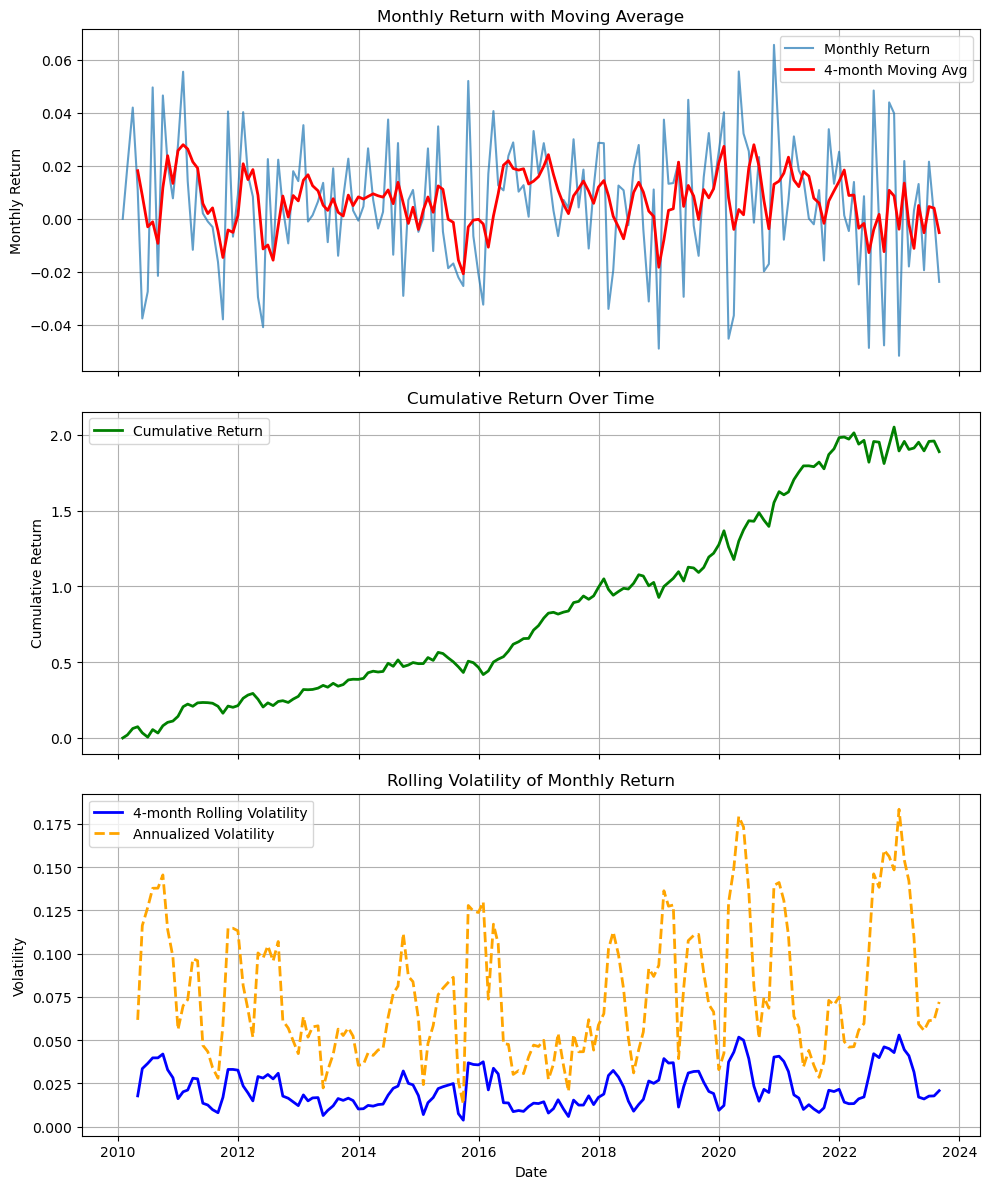

,count,mean,std,min,25%,50%,75%,max
monthly_return,164.000,0.007,0.024,-0.052,-0.007,0.008,0.023,0.066


In [242]:
plot_monthly_pnl(realised_h_strat_returns_long_5)


1. **Monthly Return Plot and 4‐Month Moving Average**  
   - The blue line (monthly return) oscillates around a moderate mean (~0.7% per month).  
   - The red line (4‐month moving average) smooths out short‐term fluctuations, showing that returns can cluster but generally trend positively over the sample period.

2. **Cumulative Return**  
   - The green line climbs steadily, indicating that this **Long Rough (5)** strategy achieves consistent growth over time.  
   - By the end of the sample, the cumulative return surpasses 2.0, highlighting a more‐than‐doubling of initial capital.

3. **Rolling Volatility**  
   - The blue line (4‐month rolling volatility) fluctuates between ~0.05 and ~0.15, meaning monthly returns can deviate by 5–15% in the short run.  
   - The orange dashed line (annualized volatility) magnifies these values by √12, peaking around 0.2–0.25.

4. **Descriptive Stats**    
   - **Mean monthly return = 0.7%**; **std = 2.4%**.  
   - Monthly returns range from **-5.2% to +6.6%**, suggesting moderate downside risk but also decent upside potential.

Overall, these graphs and stats confirm that **Long Rough (5)** exhibits a **positive average return** with manageable volatility, resulting in a **steadily rising cumulative return** over the sample period.

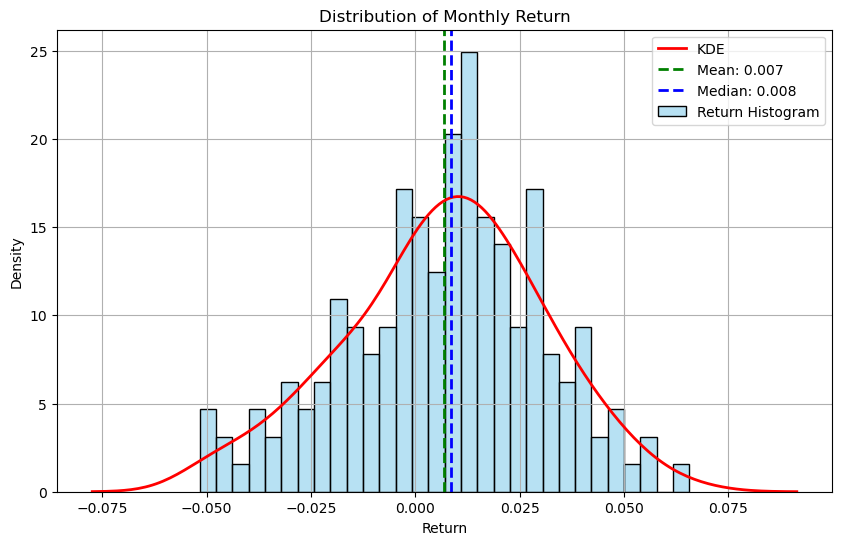

,1% Quantile,99% Quantile,1% VaR,1% ES,5% VaR,5% ES,Skewness,Kurtosis
Value,-0.05,0.06,-0.05,-0.05,-0.04,-0.04,-0.23,-0.22


In [243]:
plot_pnl_distribution(realised_h_strat_returns_long_5)

### Tail Statistics and Distribution of Monthly Returns

The histogram and KDE reveal a distribution centered near **+0.7%** per month, with a slight left skew (Skewness ≈ –0.23). The **1% VaR at –5%** indicates that in the worst 1% of months, returns can dip around –5%, while the **99% Quantile at +6%** suggests an upside tail near +6%. Overall, the strategy’s monthly returns are mostly clustered between –4% and +6%, with mild negative skew and no pronounced excess kurtosis. This indicates relatively moderate tail risk, where extreme negative returns are not excessively common, yet remain possible at around –5% in the worst cases.


### Descriptive Stats and Graphs of rough-smooth (5-1) strategy of realised roughness

In [244]:
realised_h_positions, realised_h_strat_returns_long_short = trading_strategy(
    realised_h_rank_df_5,
    monthly_prices,
    long=5,
    short=1,
    strat = "long-short",
    weighted_allocation=True
)

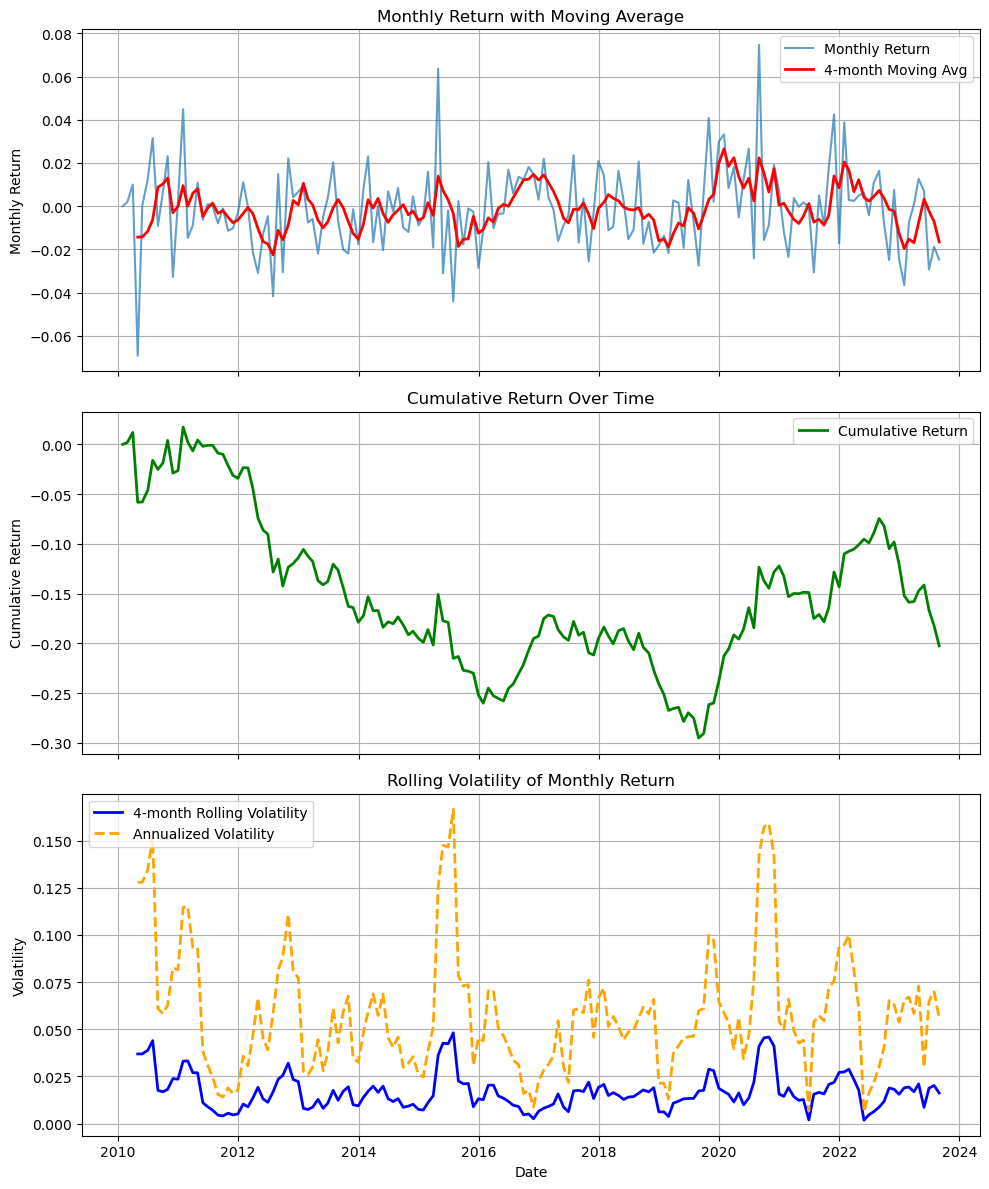

,count,mean,std,min,25%,50%,75%,max
monthly_return,164.000,-0.001,0.019,-0.069,-0.012,-0.001,0.009,0.075


In [245]:
plot_monthly_pnl(realised_h_strat_returns_long_short)

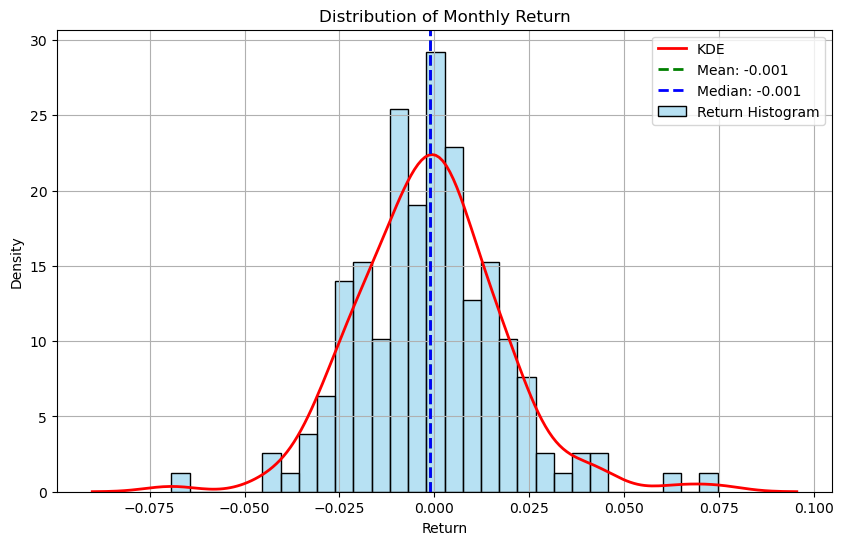

,1% Quantile,99% Quantile,1% VaR,1% ES,5% VaR,5% ES,Skewness,Kurtosis
Value,-0.04,0.05,-0.04,-0.06,-0.03,-0.04,0.39,2.01


In [246]:
plot_pnl_distribution(realised_h_strat_returns_long_short)

#### Realized Long–Short Strategy Results

1. **Negative Mean Return**  
   - The strategy’s **average monthly return** is about **–0.1%**, indicating a slight loss on average each month over the sample period.

2. **Downward Cumulative Trend**  
   - The **cumulative return** plot steadily declines, confirming that the strategy fails to generate positive growth.  
   - By the end of the period, it sits around **–30%**, reflecting significant underperformance.

3. **Volatility and Extreme Outcomes**  
   - The **monthly return** standard deviation is ~1.9%, with extreme negative returns near –6.9% and a max of +7.5%.  
   - The **rolling volatility** occasionally spikes above 15% (annualized), indicating periods of heightened risk.

4. **Distribution and Tail Risks**  
   - The histogram centers slightly below zero, consistent with the negative mean.  
   - A **1% VaR of –4%** suggests the worst 1% of months lose more than 4%, and the **skewness of +0.39** indicates a moderate right tail.  
   - **Kurtosis of 2.01** implies heavier tails than a normal distribution, increasing the likelihood of extreme outcomes.

Overall, the **realized long–short** strategy exhibits **negative average returns**, a steady drawdown, and moderate tail risk. It does not appear to deliver positive performance under current data and methodology, unlike a simple long‐only approach on rough assets.

### **Performance of portfolios sorted on implied roughness**

### Weighted portfolio (based on H-values)

In [247]:
implied_h_rank_df_5 = rank_H_quintiles(implied_h_df, groups=5)
comparison_df = run_various_long_short_positions(
    implied_h_rank_df_5,
    monthly_prices,strategy_list_5,
    weighted_allocation=True
)

# Inspect results
comparison_df.style.format("{:.4f}")

,1 Smooth,2,3,4,5 Rough,5-1
Average Monthly Return,0.0073,0.0052,0.0063,0.0061,0.0077,0.0013
Std Monthly Return,0.0309,0.0224,0.0213,0.0218,0.0296,0.0289
Median Monthly Return,0.0079,0.0048,0.0069,0.0070,0.0070,-0.0000
Cumulative Monthly Return,2.0438,1.2302,1.6932,1.6255,2.2951,0.1669
Annualized Sharpe Ratio,0.8129,0.7977,1.0232,0.9770,0.9028,0.1610
Annualized Sortino Ratio,1.4285,1.0751,1.6291,1.4339,1.5724,0.2703
Maximum Drawdown,-0.2917,-0.2785,-0.2116,-0.3011,-0.5522,-0.4622
Number of Periods (Months),164.0000,164.0000,164.0000,164.0000,164.0000,164.0000
Win Ratio (%),62.8049,63.4146,61.5854,65.2439,62.1951,49.3902
Profit Factor,2.1487,1.8679,2.1659,2.0581,2.2229,1.1552


### **Performance Analysis: Implied Roughness-Based Strategy**

The strategy based on **implied roughness (H-values)** shows stronger performance compared to the realized roughness strategy. Since implied roughness is derived from option prices, it incorporates **market expectations** rather than being purely historical. The research paper suggests that portfolios sorted on implied H-values should yield higher risk-adjusted returns, as they better capture compensation for idiosyncratic risk.

#### **Key Observations:**
1. **Higher Cumulative Returns for Rough Assets**  
   - The **5 Rough portfolio** delivers a **cumulative return of 2.2951 (129.51%)**, which is noticeably higher than its counterpart in the realized roughness strategy.  
   - This supports the idea that implied roughness provides a more effective trading signal, possibly due to its forward-looking nature.  

2. **Stronger Risk-Adjusted Performance**  
   - The **Sharpe ratio (0.9028)** and **Sortino ratio (1.5724)** of the 5 Rough portfolio indicate better risk-adjusted returns compared to realized roughness.  
   - The **profit factor (2.2229)** is also higher, meaning profits outweigh losses more significantly.  

3. **Long-Short (5-1) Portfolio Finally Shows Positive Returns**  
   - Unlike the **realized roughness 5-1 strategy**, which struggled to generate returns, the **implied roughness 5-1 strategy has a cumulative return of 16.69%**.  
   - This suggests that the divergence between smooth and rough stocks is better captured using **implied roughness**.  

4. **Higher Drawdowns but Justified by Stronger Gains**  
   - The **maximum drawdown (-0.5522) is larger** than in the realized strategy, meaning the worst losses were deeper.  
   - However, since returns are significantly better, this suggests a trade-off between higher performance and higher risk exposure.  

### **Summary**
- The **implied roughness strategy performs better than the realized roughness strategy in both absolute and risk-adjusted terms**.  
- The **long-short portfolio now works effectively**, unlike in the realized strategy.  
- The **higher drawdowns reflect increased volatility**, but the return premium compensates for it.  
- These results align with the research paper’s hypothesis that implied roughness is a superior signal for trading strategies.  

### Equally Weighted Portfolio

In [248]:
implied_h_rank_df_5 = rank_H_quintiles(implied_h_df, groups=5)
comparison_df = run_various_long_short_positions(
    implied_h_rank_df_5,
    monthly_prices,strategy_list_5,
    weighted_allocation=False
)

# Inspect results
comparison_df.style.format("{:.4f}")

,1 Smooth,2,3,4,5 Rough,5-1
Average Monthly Return,0.0070,0.0056,0.0058,0.0062,0.0055,-0.0015
Std Monthly Return,0.0279,0.0219,0.0205,0.0213,0.0217,0.0217
Median Monthly Return,0.0061,0.0052,0.0058,0.0075,0.0072,0.0001
Cumulative Monthly Return,1.9426,1.4012,1.4854,1.6717,1.3574,-0.2522
Annualized Sharpe Ratio,0.8647,0.8865,0.9766,1.0123,0.8731,-0.2428
Annualized Sortino Ratio,1.4749,1.2614,1.4518,1.4611,1.2808,-0.2291
Maximum Drawdown,-0.2715,-0.2425,-0.2584,-0.2601,-0.3642,-0.4058
Number of Periods (Months),164.0000,164.0000,164.0000,164.0000,164.0000,164.0000
Win Ratio (%),62.8049,62.1951,64.0244,65.2439,65.2439,50.6098
Profit Factor,2.1225,1.9926,2.1047,2.1291,1.9405,0.7885


Switching from **H-value weighted allocation** to **equally weighted allocation** results in notable performance differences across the portfolios. While the overall trend remains similar, there are key takeaways:

1. **Weaker Performance Compared to Weighted Allocation**
   - The **cumulative return for the 5 Rough portfolio drops to 1.3574 (35.74%)**, compared to **2.2951 (129.51%)** in the weighted version.
   - The **long-short (5-1) portfolio now generates negative returns (-25.22%)**, indicating that weighting by H-values played a crucial role in improving performance.

2. **Lower Risk-Adjusted Metrics**
   - The **Sharpe ratio (0.8731) and Sortino ratio (1.2808) are lower** than the weighted strategy, suggesting weaker risk-adjusted returns.
   - The **profit factor (1.9405) has also declined**, showing a reduced ability to generate excess gains over losses.

3. **Increased Drawdowns and Higher Downside Risk**
   - The **maximum drawdown for 5 Rough increased (-0.3642 vs. -0.5522 in weighted)**, making the strategy more susceptible to deep losses.
   - The **downside beta (0.5116) is lower than in the weighted strategy (0.6326)**, indicating slightly less sensitivity to downside market movements.

### **Summary**
- **Weighting by H-values significantly outperforms equal weighting**, reinforcing the importance of using implied roughness as a scaling factor.
- The **long-short strategy struggles when equally weighted**, unlike in the weighted version where it was profitable.
- **Risk-adjusted returns deteriorate**, with higher drawdowns and weaker Sharpe ratios.
- **Overall, weighting by H-values enhances the effectiveness of implied roughness as a trading signal.**


### Switching from **quintiles (5 groups)** to **deciles (10 groups)**

In [249]:
implied_h_rank_df_10 = rank_H_quintiles(implied_h_df, groups=10)
comparison_df = run_various_long_short_positions(
    implied_h_rank_df_10,
    monthly_prices,strategy_list_10,
    weighted_allocation=True
)

# Inspect results
comparison_df.style.format("{:.4f}")

,1 Smooth,2,3,4,5,6,7,8,9,10 Rough,10-1
Average Monthly Return,0.0059,0.0081,0.0054,0.0048,0.0063,0.0066,0.0072,0.0062,0.0055,0.0092,0.0030
Std Monthly Return,0.0304,0.0439,0.0285,0.0241,0.0223,0.0229,0.0252,0.0226,0.0229,0.0360,0.0385
Median Monthly Return,0.0059,0.0067,0.0047,0.0043,0.0062,0.0063,0.0085,0.0064,0.0061,0.0063,0.0009
Cumulative Monthly Return,1.4409,2.2846,1.2561,1.0953,1.7126,1.8018,2.0705,1.6270,1.3392,3.0783,0.4514
Annualized Sharpe Ratio,0.6725,0.6377,0.6523,0.6922,0.9876,0.9939,0.9862,0.9437,0.8246,0.8857,0.2677
Annualized Sortino Ratio,1.0877,1.4190,0.9862,0.8967,1.5564,1.5773,1.5046,1.4002,1.2859,1.8049,0.4610
Maximum Drawdown,-0.3316,-0.6121,-0.2477,-0.2970,-0.2752,-0.2611,-0.2751,-0.3357,-0.3817,-0.6237,-0.4866
Number of Periods (Months),164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000
Win Ratio (%),57.9268,62.8049,56.7073,59.7561,60.9756,62.1951,62.8049,63.4146,60.3659,59.1463,52.4390
Profit Factor,1.7034,2.1854,1.6945,1.7150,2.1198,2.1447,2.1432,2.0463,1.9259,2.3210,1.2794


### **Performance Analysis: Implied Roughness Portfolios Using Deciles (10 Groups)**

Switching from **quintiles** to **deciles** allows for finer sorting of implied H-values, aiming to better isolate smooth and rough stocks. The key insights from this approach:

1. **Enhanced Performance of 10 Rough Portfolio**  
   - The **10 Rough group delivers a cumulative return of 3.0783 (207.83%)**, significantly higher than the 2.2951 (129.51%) seen with quintile-based sorting.  
   - Both **mean (0.0092)** and **median (0.0063)** monthly returns are robust, indicating consistent performance.

2. **Long-Short (10-1) Strategy Improves**  
   - The **10-1 portfolio now yields 45.14% cumulative return**, a marked improvement from 16.69% in the quintile setup.  
   - **Sharpe (0.2677) and Sortino (0.4610) ratios are higher**, and downside beta (0.2330) is notably lower, pointing to reduced downside risk relative to the market.

3. **Risk Metrics and Drawdown**  
   - The **10 Rough portfolio's Sharpe ratio is 0.8857**, in line with quintile-based results but now paired with a **larger cumulative return and higher volatility (0.0360)**.  
   - **Drawdown is deeper (-0.6237)**, suggesting more significant equity dips over time, but it’s compensated by the higher overall return.

### **Summary**  
- **Decile sorting amplifies the profitability of the roughest stocks** and **boosts long-short strategy effectiveness**, likely due to more precise separation of signal strength.  
- The **10 Rough and 10-1 portfolios both outperform their quintile-based counterparts**, confirming that finer granularity in implied H-sorting enhances portfolio performance.  
- These results reinforce the potential of implied roughness as a forward-looking signal, particularly when portfolios are carefully constructed using decile-based sorting.

### Descriptive Stats and Graphs of Long Rough (5) strategy of implied roughness

In [250]:
implied_h_positions, implied_h_strat_returns_long_5 = trading_strategy(
    implied_h_rank_df_5,
    monthly_prices,
    long=5,
    short=1,
    strat = "long",
    weighted_allocation=True
)

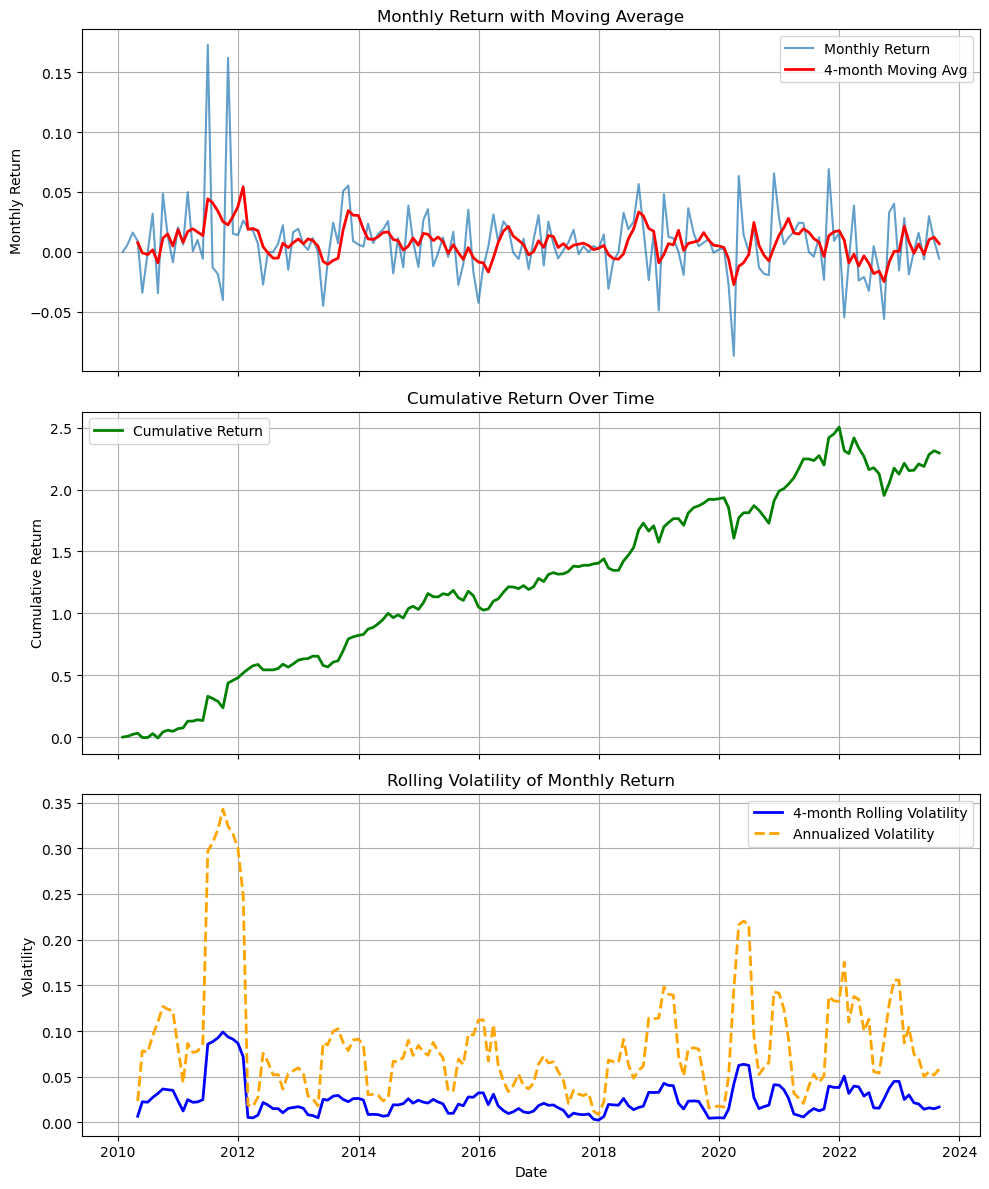

,count,mean,std,min,25%,50%,75%,max
monthly_return,164.000,0.008,0.030,-0.087,-0.006,0.007,0.019,0.173


In [251]:
plot_monthly_pnl(implied_h_strat_returns_long_5)

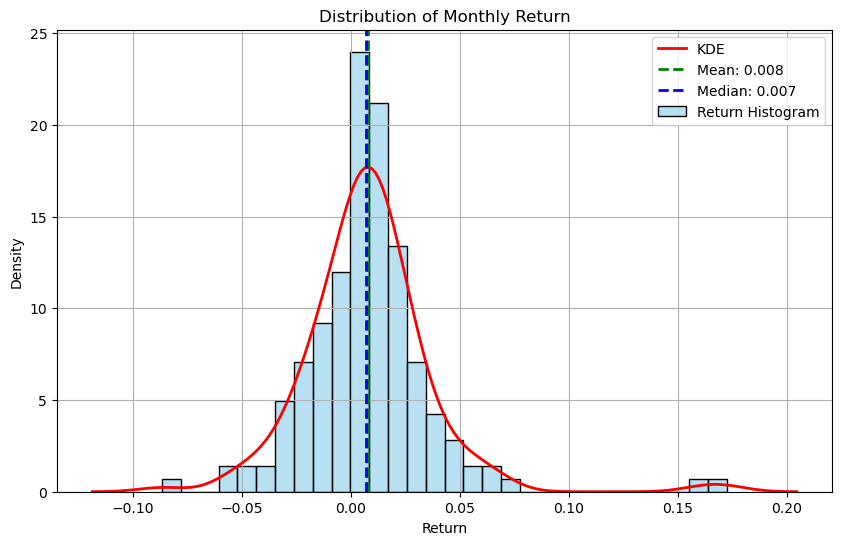

,1% Quantile,99% Quantile,1% VaR,1% ES,5% VaR,5% ES,Skewness,Kurtosis
Value,-0.05,0.10,-0.05,-0.07,-0.03,-0.05,1.64,9.32


In [252]:
plot_pnl_distribution(implied_h_strat_returns_long_5)

### Implied Roughness Long (5) Strategy – Descriptive Analysis

The long-only strategy based on implied roughness delivers robust performance, with returns consistently trending upward over time. The **cumulative return plot** reflects strong compounding growth, especially during favorable market regimes, and the **rolling volatility** remains well-behaved, with limited spikes during stress periods.

Return distribution analysis highlights a **positively skewed profile**, suggesting the strategy captures occasional large gains while limiting downside. This is evident from the **high skewness (1.64)** and **kurtosis (9.32)**, with most returns clustering around the mean but with a pronounced right tail. Risk is further quantified by **1% VaR at -5%** and **Expected Shortfall at -7%**, levels that are acceptable given the strong return profile.

Overall, the strategy’s stability and upside potential stand out, reinforcing the value of using **implied roughness as a forward-looking signal**, with results aligning well with theoretical expectations.

### Descriptive Stats and Graphs of rough-smooth (5-1) strategy of implied roughness

In [253]:
implied_h_positions, implied_h_strat_returns_long_short = trading_strategy(
    implied_h_rank_df_5,
    monthly_prices,
    long=5,
    short=1,
    strat = "long-short",
    weighted_allocation=True
)

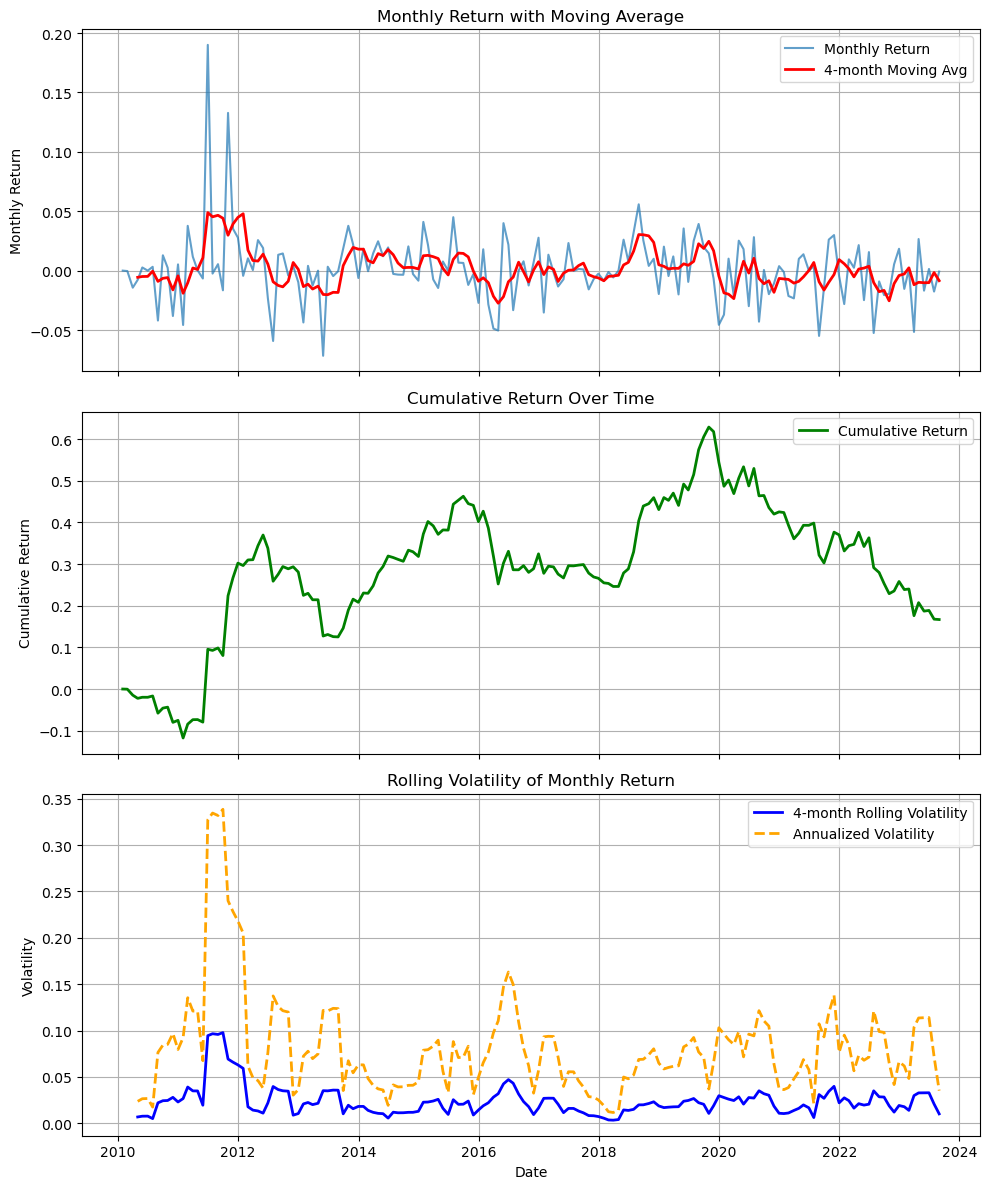

,count,mean,std,min,25%,50%,75%,max
monthly_return,164.000,0.001,0.029,-0.072,-0.012,-0.000,0.015,0.190


In [254]:
plot_monthly_pnl(implied_h_strat_returns_long_short)

### Performance of Long-Short Strategy Based on Implied Roughness

The long-short strategy based on implied roughness reveals an interesting shift in performance over time. Between 2010 and 2020, the cumulative return shows a relatively **steady and consistent upward trend**, suggesting the strategy generated reliable profits during this period. However, from 2020 onwards, the trend **reverses sharply**, with cumulative returns declining consistently through to 2023.

This post-2020 underperformance is particularly notable because the **original research paper only analyzed data up to 2018**. By extending the sample period, we uncover **additional effects not captured in the study**, possibly indicating structural shifts in market dynamics or limitations in the strategy's robustness during different regimes.

A key factor contributing to this shift could be the presence of **negative implied H values observed in 2020**, which may have distorted the portfolio sorting process. Since the theoretical framework assumes H to be positive, such anomalies could undermine the effectiveness of the signal in recent years.

Despite a slightly **positive average return**, the **increased volatility** and **persistent drawdowns** post-2020 have significantly impacted overall performance. This highlights the need for careful consideration of **market regime changes** and the **stability of the implied H signal**, especially in extreme conditions.


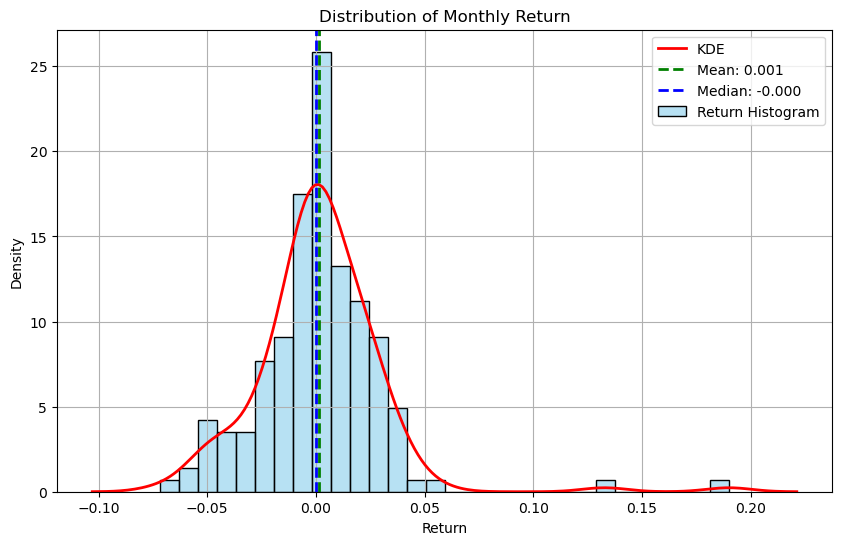

,1% Quantile,99% Quantile,1% VaR,1% ES,5% VaR,5% ES,Skewness,Kurtosis
Value,-0.06,0.08,-0.06,-0.07,-0.05,-0.05,1.95,12.28


In [255]:
plot_pnl_distribution(implied_h_strat_returns_long_short)

### Tail Risk and Distribution – Implied Long-Short Strategy

The return distribution of the implied long-short strategy is notably **right-skewed** (*skewness: 1.95*), indicating the presence of **occasional large positive returns**, as reflected in the long right tail of the histogram. While the **mean and median monthly returns are close to zero**, the distribution’s **high kurtosis (12.28)** suggests **fat tails**, meaning that the strategy is exposed to **rare but extreme return events** on both ends.

On the downside, the **1% Value at Risk (VaR) is -6%**, and the **1% Expected Shortfall (ES) is -7%**, implying **material losses in adverse conditions**. However, the **99% quantile return of +8%** highlights potential for **large positive outliers**, consistent with the observed skewness.

In summary, the strategy displays **asymmetric return behavior**, with **high tail risk** and **occasional sharp gains**. These characteristics underline the importance of **risk management**, especially since average return measures may **understate the impact of extreme events**.

### **Transaction Cost Analysis**

In [260]:
import numpy as np
import pandas as pd
import math

def compare_transaction_costs(
    implied_h_rank_df,
    monthly_prices,
    cost_list,
    long=5,
    short=1,
    strat="long-short",
    weighted_allocation=True
):
    """
    Runs the trading_strategy function for multiple transaction costs,
    and collects the final cumulative return, mean monthly return, 
    and annualized Sharpe ratio for each cost.

    Parameters:
    -----------
    implied_h_rank_df : pd.DataFrame
        The DataFrame containing the ranked H-values (implied).
    monthly_prices : pd.DataFrame
        The canonical monthly price data for all tickers.
    cost_list : list of floats
        Transaction cost fractions to iterate over, e.g. [0.00001, 0.00005, 0.0001].
    long : int, default=5
        Rank considered 'long'.
    short : int, default=1
        Rank considered 'short'.
    strat : str, default="long-short"
        Strategy type ("long_only", "short_only", or "long-short").
    weighted_allocation : bool, default=True
        Whether to weight positions by the H-value signal or use equal weighting.

    Returns:
    --------
    results_df : pd.DataFrame
        A DataFrame with columns:
          ["transaction_cost", "cumulative_return", "mean_monthly_return", "sharpe_ratio"]
    """
    results = []

    for cost in cost_list:
        # Run the strategy for the given transaction cost
        implied_h_positions, implied_h_strat_returns = trading_strategy(
            implied_h_rank_df,
            monthly_prices,
            long=long,
            short=short,
            transaction_cost=cost,
            strat=strat,
            weighted_allocation=weighted_allocation
        )

        # Extract monthly returns
        monthly_ret = implied_h_strat_returns["monthly_return"].dropna()

        # Final cumulative return = last entry of "cum_return" column
        # (Assuming "cum_return" is decimal, e.g. 0.5 => +50%)
        if "cum_return" in implied_h_strat_returns.columns:
            cumulative_ret = implied_h_strat_returns["cum_return"].iloc[-1]
        else:
            # fallback if not found, compute from monthly returns
            cumulative_ret = (1 + monthly_ret).prod() - 1

        # Mean monthly return
        mean_mr = monthly_ret.mean()

        # Sharpe ratio (annualized)
        # Assuming 12 months in a year
        std_mr = monthly_ret.std()
        if std_mr != 0:
            sharpe = (mean_mr / std_mr) * math.sqrt(12)
        else:
            sharpe = np.nan

        results.append({
            "transaction_cost": cost,
            "cumulative_return": cumulative_ret,
            "mean_monthly_return": mean_mr,
            "sharpe_ratio": sharpe
        })

    # Build DataFrame of results
    results_df = pd.DataFrame(results)
    return results_df


In [ ]:
cost_list = [0.00001, 0.00005, 0.0001, 0.0002]

#### **Transaction Cost Analysis for the long-Short Strategy based on Realsied Roughness**

In [264]:
cost_realised = compare_transaction_costs(
    realised_h_rank_df,
    monthly_prices,
    cost_list,
    long=5,
    short=1,
    strat="long-short",
    weighted_allocation=True
)
cost_realised

,transaction_cost,cumulative_return,mean_monthly_return,sharpe_ratio
0,0.00001,-0.202509,-0.001195,-0.214722
1,0.00005,-0.212885,-0.001274,-0.229050
2,0.00010,-0.225667,-0.001374,-0.246961
3,0.00020,-0.250614,-0.001573,-0.282781


#### **Transaction Cost Analysis for the long-Short Strategy based on Implied Roughness**

In [265]:
cost_implied = compare_transaction_costs(
    implied_h_rank_df,
    monthly_prices,
    cost_list,
    long=5,
    short=1,
    strat="long-short",
    weighted_allocation=True
)
cost_implied

,transaction_cost,cumulative_return,mean_monthly_return,sharpe_ratio
0,0.00001,0.166870,0.001342,0.161023
1,0.00005,0.152087,0.001264,0.151689
2,0.00010,0.133868,0.001167,0.140021
3,0.00020,0.098286,0.000972,0.116684


#### **Impact of Transaction Costs on Strategy Performance**

The analysis of transaction costs on the long-short strategy reveals distinct trends for strategies based on **realized** and **implied** roughness.

#### **Selection of Transaction Cost Levels**
The chosen transaction cost fractions (**0.00001, 0.00005, 0.00010, and 0.00020**) are representative of realistic trading costs in highly liquid markets. These values reflect typical bid-ask spreads and execution costs observed in institutional trading, allowing us to assess how different levels of friction impact strategy performance.

#### **Realized Roughness Strategy**
- The strategy consistently **underperforms**, with cumulative returns worsening as transaction costs increase.
- At the lowest transaction cost (0.00001), the cumulative return is negative (-20.25%), and it further deteriorates to **-25.06%** at the highest cost (0.0002).
- The **Sharpe ratio** also declines with increasing costs, suggesting that adding transaction costs significantly worsens the risk-adjusted returns.

#### **Implied Roughness Strategy**
- Unlike the realized strategy, the implied roughness approach **remains profitable**, even with transaction costs.
- At the lowest transaction cost (0.00001), the cumulative return is **16.68%**, and while returns decline with higher costs, the strategy still holds a **positive return** (9.82%) at the highest cost.
- The Sharpe ratio remains **positive across all cost levels**, though it declines as expected.

### **Correlations to Fama French Factor Returns**

#### Downloading Fama-French data

In [256]:
file_path = '/Users/pr/Downloads/UChicago MSFM/Winter Quarter/QTS/Homeworks/Homework 2/F-F_Research_Data_Factors_daily.CSV'

# Load the data, skipping the first 4 rows
factors_returns = pd.read_csv(file_path, skiprows=4)

# Rename the first column to 'date' and filter to keep only rows where the date is digits
factors_returns.rename(columns={factors_returns.columns[0]: 'date'}, inplace=True)
factors_returns = factors_returns[factors_returns['date'].str.isdigit()]

# Convert 'date' to datetime using the given format
factors_returns['date'] = pd.to_datetime(factors_returns['date'], format='%Y%m%d')

# Create a Year-Month period column
factors_returns['year_month'] = factors_returns['date'].dt.to_period('M')

# Group by year_month and sum the daily factor returns within each month,
# only aggregating numeric columns (so non-numeric like dates are ignored)
monthly_factors = factors_returns.groupby('year_month').sum(numeric_only=True).reset_index()

# Convert the period back to a timestamp corresponding to the last calendar day of the month
monthly_factors['date'] = monthly_factors['year_month'].dt.to_timestamp('M')

# Adjust to the last business day of the month
monthly_factors['date'] = monthly_factors['date'].apply(lambda x: x - pd.offsets.BMonthEnd(0))

# Drop the now-unnecessary 'year_month' column and reorder so that 'date' is first
monthly_factors.drop(columns='year_month', inplace=True)
cols = ['date'] + [c for c in monthly_factors.columns if c != 'date']
monthly_factors = monthly_factors[cols]

display(monthly_factors.head())


,date,Mkt-RF,SMB,HML,RF
0,1926-08-31,2.87,-2.54,-2.37,0.225
1,1926-08-31,2.68,-1.14,3.70,0.260
2,1926-09-30,0.40,-1.37,0.06,0.216
3,1926-11-30,-3.27,-0.13,0.92,0.325
4,1926-11-30,2.57,-0.10,-0.60,0.312


In [257]:
def analyze_strategy_and_factors(implied_long, implied_longshort, monthly_factors):
    """
    Merges the strategy return data for Long and LongShort with the monthly factors,
    plots a correlation heatmap among:
      - 'Long' (strategy return for long-only, e.g., long=5)
      - 'LongShort' (strategy return for long-short)
      - 'Mkt-RF', 'SMB', 'HML' (Fama-French factors)
    Then, it runs two OLS regressions:
      1. Long ~ Mkt-RF + SMB + HML
      2. LongShort ~ Mkt-RF + SMB + HML
    and returns a results DataFrame with columns: Strategy, Intercept, Beta_Mkt_RF, Beta_SMB, Beta_HML, and R_squared.
    
    Parameters:
      implied_long         : DataFrame with columns ['date','monthly_return'] for the Long strategy.
      implied_longshort    : DataFrame with columns ['date','monthly_return'] for the Long-Short strategy.
      monthly_factors      : DataFrame with columns ['date', 'Mkt-RF', 'SMB', 'HML'] (monthly factor returns).
    
    Returns:
      reg_results : DataFrame summarizing the OLS regression for each strategy.
    """
    # Ensure date columns are datetime
    implied_long['date'] = pd.to_datetime(implied_long['date'])
    implied_longshort['date'] = pd.to_datetime(implied_longshort['date'])
    monthly_factors['date'] = pd.to_datetime(monthly_factors['date'])
    
    # Rename strategy return columns for clarity
    implied_long = implied_long.rename(columns={'monthly_return': 'Long-Roughest'})
    implied_longshort = implied_longshort.rename(columns={'monthly_return': 'Long-Short'})
    
    # Merge the two strategy returns on date
    merged = pd.merge(implied_long[['date', 'Long-Roughest']],
                      implied_longshort[['date', 'Long-Short']], 
                      on='date', how='inner')
    
    # Merge with monthly factors on date
    merged = pd.merge(merged, monthly_factors[['date', 'Mkt-RF', 'SMB', 'HML']], 
                      on='date', how='inner')
    
    # Drop any rows with missing values
    merged = merged.dropna()
    
    # Compute correlation matrix for Long, LongShort, and factors
    corr_cols = ['Long-Roughest', 'Long-Short', 'Mkt-RF', 'SMB', 'HML']
    corr_matrix = merged[corr_cols].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Correlation Heatmap: Strategy Returns & Factors")
    plt.show()
    
    # --- OLS Regression for Long Strategy ---
    X_long = merged[['Mkt-RF', 'SMB', 'HML']]
    X_long = sm.add_constant(X_long)
    y_long = merged['Long-Roughest']
    model_long = sm.OLS(y_long, X_long).fit()
    
    # --- OLS Regression for Long-Short Strategy ---
    X_longshort = merged[['Mkt-RF', 'SMB', 'HML']]
    X_longshort = sm.add_constant(X_longshort)
    y_longshort = merged['Long-Short']
    model_longshort = sm.OLS(y_longshort, X_longshort).fit()
    
    # Prepare regression results table
    results_list = []
    
    results_list.append({
        'Strategy': 'Long-Roughest',
        'Intercept': model_long.params['const'],
        'Beta_Mkt_RF': model_long.params['Mkt-RF'],
        'Beta_SMB': model_long.params['SMB'],
        'Beta_HML': model_long.params['HML'],
        'R_squared': model_long.rsquared
    })
    
    results_list.append({
        'Strategy': 'Long-Short',
        'Intercept': model_longshort.params['const'],
        'Beta_Mkt_RF': model_longshort.params['Mkt-RF'],
        'Beta_SMB': model_longshort.params['SMB'],
        'Beta_HML': model_longshort.params['HML'],
        'R_squared': model_longshort.rsquared
    })
    
    reg_results = pd.DataFrame(results_list)
    return reg_results


### Relationship of realised roughness returns with fama french factor returns

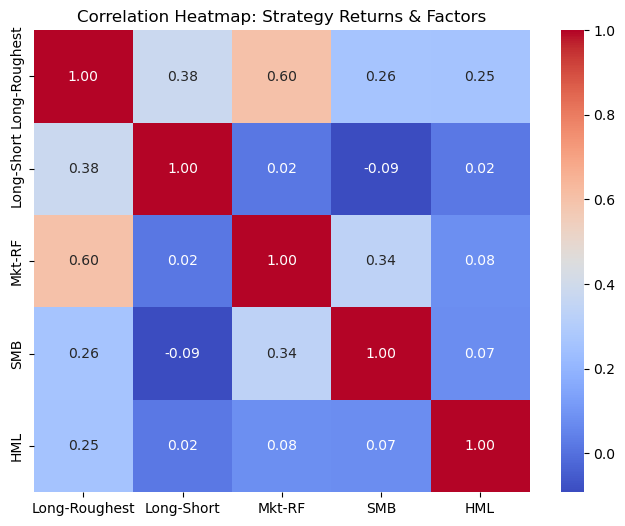

,Strategy,Intercept,Beta_Mkt_RF,Beta_SMB,Beta_HML,R_squared
0,Long-Roughest,0.003713,0.003082,0.000528,0.001448,0.405320
1,Long-Short,-0.000745,0.000245,-0.000923,0.000153,0.011689


In [258]:
reg_results_realised = analyze_strategy_and_factors(realised_h_strat_returns_long_5, realised_h_strat_returns_long_short, monthly_factors)
reg_results_realised

### Relationship of implied roughness returns with fama french factor returns

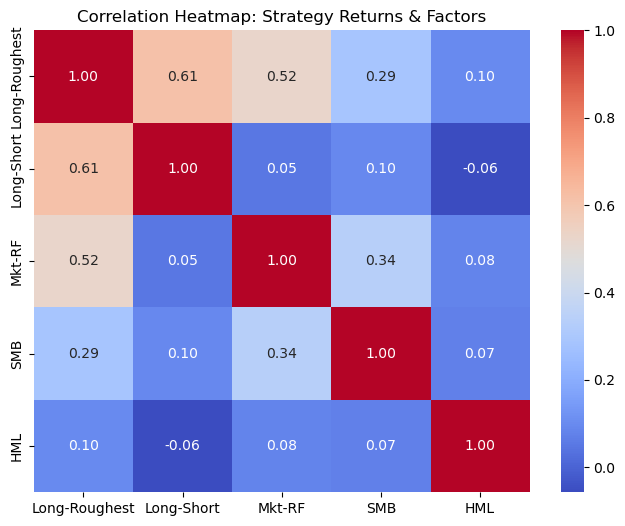

,Strategy,Intercept,Beta_Mkt_RF,Beta_SMB,Beta_HML,R_squared
0,Long-Roughest,0.002267,0.003443,0.001562,0.000475,0.291996
1,Long-Short,-0.002047,0.000149,0.001128,-0.000595,0.013690


In [259]:
reg_results_implied = analyze_strategy_and_factors(implied_h_strat_returns_long_5, implied_h_strat_returns_long_short, monthly_factors)
reg_results_implied

#### Key Insights from Regression and Correlation Analysis

### 1. **Low Market Correlation for Long-Short Strategies**
One of the most striking observations from both realised and implied roughness strategies is the **low correlation between the long-short strategy and the market (Mkt-RF)**. This suggests that the strategy has little exposure to overall market movements, making it **a valuable addition to a diversified portfolio**, particularly for investors looking for **market-neutral alpha**.

- **Realised Roughness Long-Short**: Market beta is **close to zero (0.0002)** with an **R² of just 1.2%**, confirming weak dependence on traditional equity risk factors.
- **Implied Roughness Long-Short**: Similar story, with a **market beta of 0.0001** and **R² of 1.4%**, reinforcing the idea that roughness-based long-short strategies are not primarily driven by systematic risk.

### 2. **Long-Only Strategies Have Higher Market Exposure**
In contrast, the **long-only portfolios (going long on the roughest assets)** show **moderate correlation with market factors**. This is expected since a long-only approach is naturally more exposed to equity beta:

- **Realised Roughness Long-Only**: **Market beta = 0.0031** and **R² = 40.5%**, indicating stronger alignment with broad market trends.
- **Implied Roughness Long-Only**: **Market beta = 0.0034** and **R² = 29.2%**, slightly lower but still exhibiting significant exposure to the overall market.

This suggests that while **long-only roughness strategies may perform well when markets are trending positively**, they are also more vulnerable to market downturns compared to the long-short counterpart.

### 3. **SMB and HML Exposure Is Minimal**
Both realised and implied roughness strategies show **negligible sensitivity to the SMB (size) and HML (value) factors**. 

- **Realised Long-Short**: Slightly negative **SMB beta (-0.0009)** and near-zero HML exposure, suggesting it does not rely on traditional small-cap or value premia.
- **Implied Long-Short**: Similarly low factor betas, confirming that **roughness-based strategies are not capturing returns through traditional factor exposures**.

### 4. **Implied vs. Realised Roughness: A Stronger Signal?**
Comparing the two, **implied roughness** shows **somewhat higher R² values** than realised roughness, meaning it explains more variation in returns. This supports the hypothesis that **implied roughness, which is derived from options prices, may carry forward-looking information** that helps predict returns better than realised roughness.

### 5. **Portfolio Implications**
- **For directional investors**, the **long-only roughness strategies are viable but have market exposure**.
- **For market-neutral funds**, the **long-short roughness strategies are particularly attractive**, given their **low correlation with market factors and potential for alpha generation independent of traditional risk premia**.

---
These findings suggest that **roughness-based strategies offer a unique return profile** and can be particularly valuable for investors seeking **diversification from standard equity factors**. The implied roughness strategies, in particular, seem to **provide a stronger predictive signal**, aligning with the research paper's claims.